<div align='center'><font size="5" color='#353B47'>Opracowanie aplikacji do wyznaczania giełdowych decyzji inwestycyjnych opartej na analizie Big Data</font></div>
<div align='center'><font size="4" color="#353B47">Projekt Inżynierski</font></div>
<br>
<hr>

**<font color="#5963ab" size="4">Cel projektu</font>**

> Celem projektu jest opracowanie narzędzia do wspierania wyznaczania trendów na podstawie różnych danych dostępnych w internecie. Umożliwi to inwestorom podejmowanie bardziej trafnych i opartych na danych decyzji inwestycyjnych.

## <div id="summary">Spis Treści</div>

**<br><font size="2"><a href="#chap1">Konfiguracja środowiska</a></font>**
**<br><font size="2"><a href="#chap2">Wczytanie danych</a></font>**
**<br><font size="2"><a href="#chap3">Analiza danych</a></font>**
**<br><font size="2"><a href="#chap4">Przetwarzanie wstępne danych</a></font>**
**<br><font size="2"><a href="#chap5">Stworzenie modeli</a></font>**
**<br><font size="2"><a href="#chap6">Backtesting modeli i optymalizacja</a></font>**
**<br><font size="2"><a href="#chap7">Ocena modeli</a></font>**
**<br><font size="2"><a href="#chap8">Zastosowanie wyników w rzeczywistości</a></font>**
**<br><font size="2"><a href="#chap9">Wnioski z uzyskanych danych</a></font>**
**<br><font size="2"><a href="#chap10">Raport końcowy</a></font>**


<div id="chap1"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Konfiguracja środowiska </h1></div>

In [1]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# linear algebra
import numpy as np 

# data processing
import pandas as pd

# import data
import yfinance as yf

# data analysis
from statsmodels.graphics.tsaplots import month_plot
from statistics import mean

# text formatting
from pprint import pprint

# natural language processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jimiolo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div id="chap2"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Wczytanie danych</h1></div>



**<font color="#5963ab" size="4">Dane są wykorzystane i ich pochodzenie.</font>**

>Oto dane użyte w projekcie oraz ich pochodzenie:
>* **Notowania S&P 500** - pobrane z użyciem biblioteki *yfinance*
>* **Nagłówki artykułów z New York Times** - pobrane za pomocą API dostarczanego przez NYT - https://developer.nytimes.com/
>* **Dane makroekonomiczne gospodarki USA i podstawowe wskaźniki dla S&P 500** - pobrane z:
>   * https://data.nasdaq.com/
>   * https://fred.stlouisfed.org/
>   * https://www.bls.gov/
>   * https://stooq.pl/
>* **Wyszukiwanie frazy "S&P 500" w wyszukiwarce** - pobrano dane z wyszukiwarki google ze strony - https://trends.google.com/trends/
>
>Powyższe dane są w dalszych etapach poddane analizie oraz wstępnie przetworzone w celu wykorzystania ich a modelach uczenia maszynowego.
>
>W projekcie skupiono się na danych związanych z indeksem S&P 500, gospodarką Stanów Zjednoczonych, nagłówkami artykułów z NYT, trendami wyszukiwania frazy "S&P 500" w wyszukiwarce google. Na podstawie danych z notowań wyznaczono też wiele wskaźników pomocnych przy analizie technicznej, których także użyto do predykcji notowań. Dane pochodzą z okresu od 01/01/2004 do 08/31/2023.

**<font color="#5963ab" size="4">Notowania S&P 500</font>**

In [2]:
# get S&P 500 financial data
try:
    # fetch from yfinance
    sp500 = yf.Ticker("^GSPC")
    
    #print all index info
    #pprint("Info")
    #pprint(sp500.info)

    #get stock quotes
    sp500 = sp500.history( period="max" )
    start_date = '2004-01-01'
    end_date = '2023-08-31'
    sp500 = sp500[(sp500.index >= start_date) & (sp500.index <= end_date)]

except Exception as e:
    # catch any other unexpected exceptions
    print(f"An unexpected error occurred: {e}")
    # load the dataset
    sp500 = pd.read_csv('data/SP500_Stock_Quotes.csv', index_col='date')
    sp500.index = pd.DatetimeIndex(sp500.index, tz='America/New_York')
    

# make all column headers and index name lowercase
sp500.columns = sp500.columns.str.lower()
sp500.index.name = sp500.index.name.lower()

sp500

,open,high,low,close,volume,dividends,stock splits
date,,,,,,,
2004-01-02 00:00:00-05:00,1111.920044,1118.849976,1105.079956,1108.479980,1153200000,0.0,0.0
2004-01-05 00:00:00-05:00,1108.479980,1122.219971,1108.479980,1122.219971,1578200000,0.0,0.0
2004-01-06 00:00:00-05:00,1122.219971,1124.459961,1118.439941,1123.670044,1494500000,0.0,0.0
2004-01-07 00:00:00-05:00,1123.670044,1126.329956,1116.449951,1126.329956,1704900000,0.0,0.0
2004-01-08 00:00:00-05:00,1126.329956,1131.920044,1124.910034,1131.920044,1868400000,0.0,0.0
...,...,...,...,...,...,...,...
2023-08-25 00:00:00-04:00,4389.379883,4418.459961,4356.290039,4405.709961,3296180000,0.0,0.0
2023-08-28 00:00:00-04:00,4426.029785,4439.560059,4414.979980,4433.310059,2957230000,0.0,0.0
2023-08-29 00:00:00-04:00,4432.750000,4500.140137,4431.680176,4497.629883,3354820000,0.0,0.0


**<font color="#5963ab" size="4">Nagłówki New York Times </font>**

In [3]:
# load the dataset
nyt_hl = pd.read_csv('data/NYT_Headlines.csv', index_col='date',  encoding='utf-8')
nyt_hl.index = pd.to_datetime(nyt_hl.index)
nyt_hl.index = nyt_hl.index.tz_localize('America/New_York')
nyt_hl

,headline
date,
2004-01-01 00:00:00-05:00,FreeMarkets Agrees to Buy Auction Unit of Covi...
2004-01-01 00:00:00-05:00,National Briefing | South: Arkansas: Assembly ...
2004-01-01 00:00:00-05:00,Clark Courts Veterans in Swing Through South
2004-01-01 00:00:00-05:00,"Paid Notice: Deaths PAONE, NICOLA"
2004-01-01 00:00:00-05:00,The Time We Thought We Knew
...,...
2023-08-31 00:00:00-04:00,Yale’s President Announces He Will Step Down
2023-08-31 00:00:00-04:00,7 Spectacular Space Images From August
2023-08-31 00:00:00-04:00,"Trump, Waiving Arraignment, Pleads Not Guilty ..."


**<font color="#5963ab" size="4">Dane makroekonomiczne gospodarki USA i podstawowe wskaźniki dla S&P 500</font>**

In [4]:
# load the dataset
macro_data = pd.read_csv('data/USA_SP500_Fundamentals_2004_2023_Combined.csv', index_col='date')
macro_data.index = pd.to_datetime(macro_data.index)
# make all column headers lowercase
macro_data.columns = macro_data.columns.str.lower()
macro_data.index = macro_data.index.tz_localize('America/New_York')
macro_data

,cape,div_growth,div_yield,earn_yield,pbv,pe,price_sales_ratio,10usy_bond_yield,cons_sent,cons_sent_percent_change,cpiaucsl_pch,fed_effective_rate,fed_effect_rate_pch,gdp,gdp_percent_change,pmi_index,unemploy_rate
date,,,,,,,,,,,,,,,,,
2004-01-01 00:00:00-05:00,27.66,8.16,1.61,4.40,3.03,22.73,1.56,4.26,103.8,12.10,0.43,1.00,0.02,11923.45,1.28,60.8,5.7
2004-01-02 00:00:00-05:00,27.66,8.16,1.61,4.40,3.03,22.72,1.56,4.37,103.8,12.10,0.43,1.00,0.02,11923.45,1.28,60.8,5.7
2004-01-03 00:00:00-05:00,27.66,8.16,1.61,4.40,3.03,22.71,1.56,4.37,103.8,12.10,0.43,1.00,0.02,11923.45,1.28,60.8,5.7
2004-01-04 00:00:00-05:00,27.66,8.16,1.61,4.40,3.03,22.70,1.56,4.37,103.8,12.10,0.43,1.00,0.02,11923.45,1.28,60.8,5.7
2004-01-05 00:00:00-05:00,27.66,8.16,1.61,4.40,3.03,22.70,1.56,4.39,103.8,12.10,0.43,1.00,0.02,11923.45,1.28,60.8,5.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-27 00:00:00-04:00,31.36,7.33,1.50,3.85,4.47,25.76,2.61,4.23,69.5,-2.93,0.60,5.33,0.21,26798.60,1.01,46.4,3.8
2023-08-28 00:00:00-04:00,31.36,7.33,1.50,3.85,4.47,25.75,2.61,4.21,69.5,-2.93,0.60,5.33,0.21,26798.60,1.01,46.4,3.8
2023-08-29 00:00:00-04:00,31.36,7.33,1.50,3.85,4.47,25.74,2.61,4.12,69.5,-2.93,0.60,5.33,0.21,26798.60,1.01,46.4,3.8


>Podzielenie danych na dwa zbiory. Pierwszy mający dane dotyczące S&P 500 - **sp500_rates** oraz drugi związany z danymi makroekonomicznymi Stanów Zjednoczonych - **usa_eco_rates**

In [7]:
# divide data to two data frames
# data related with S&P 500 
sp500_rates = macro_data[['pe', 'cape', 'earn_yield','pbv', 'price_sales_ratio','div_yield', 'div_growth']]
sp500_rates

,pe,cape,earn_yield,pbv,price_sales_ratio,div_yield,div_growth
date,,,,,,,
2004-01-01 00:00:00-05:00,22.73,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-02 00:00:00-05:00,22.72,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-03 00:00:00-05:00,22.71,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-04 00:00:00-05:00,22.70,27.66,4.40,3.03,1.56,1.61,8.16
2004-01-05 00:00:00-05:00,22.70,27.66,4.40,3.03,1.56,1.61,8.16
...,...,...,...,...,...,...,...
2023-08-27 00:00:00-04:00,25.76,31.36,3.85,4.47,2.61,1.50,7.33
2023-08-28 00:00:00-04:00,25.75,31.36,3.85,4.47,2.61,1.50,7.33
2023-08-29 00:00:00-04:00,25.74,31.36,3.85,4.47,2.61,1.50,7.33


In [8]:
# data related with USA economy
usa_eco_rates = macro_data[['gdp', 'gdp_percent_change', 'unemploy_rate','pmi_index', 'cpiaucsl_pch','fed_effective_rate', 'fed_effect_rate_pch','10usy_bond_yield', 'cons_sent',
       'cons_sent_percent_change']]
usa_eco_rates

,gdp,gdp_percent_change,unemploy_rate,pmi_index,cpiaucsl_pch,fed_effective_rate,fed_effect_rate_pch,10usy_bond_yield,cons_sent,cons_sent_percent_change
date,,,,,,,,,,
2004-01-01 00:00:00-05:00,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.26,103.8,12.10
2004-01-02 00:00:00-05:00,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.37,103.8,12.10
2004-01-03 00:00:00-05:00,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.37,103.8,12.10
2004-01-04 00:00:00-05:00,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.37,103.8,12.10
2004-01-05 00:00:00-05:00,11923.45,1.28,5.7,60.8,0.43,1.00,0.02,4.39,103.8,12.10
...,...,...,...,...,...,...,...,...,...,...
2023-08-27 00:00:00-04:00,26798.60,1.01,3.8,46.4,0.60,5.33,0.21,4.23,69.5,-2.93
2023-08-28 00:00:00-04:00,26798.60,1.01,3.8,46.4,0.60,5.33,0.21,4.21,69.5,-2.93
2023-08-29 00:00:00-04:00,26798.60,1.01,3.8,46.4,0.60,5.33,0.21,4.12,69.5,-2.93


**<font color="#5963ab" size="4">Trendy wyszukiwania "S&P 500" w wyszukiwarce google</font>**

In [9]:
# load the dataset
goog_trend = pd.read_csv('data/SP500_GoogleTrends.csv', index_col='date')
goog_trend.index = pd.to_datetime(goog_trend.index)
goog_trend.index = goog_trend.index.tz_localize('America/New_York')
goog_trend

,month_trend
date,
2004-01-01 00:00:00-05:00,10
2004-02-01 00:00:00-05:00,9
2004-03-01 00:00:00-05:00,8
2004-04-01 00:00:00-05:00,9
2004-05-01 00:00:00-04:00,7
...,...
2023-04-01 00:00:00-04:00,35
2023-05-01 00:00:00-04:00,35
2023-06-01 00:00:00-04:00,38


<div id="chap3"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Analiza danych</h1></div>

**<font color="#5963ab" size="4">Dane z szeregów czasowych.</font>**

>W danym notatniku mamy do czynienia z danymi z szeregów czasowych. Dane z szeregów czasowych (ang. "time series data") to rodzaj danych, w którym informacje są zbierane, zapisywane lub pomiarowe w określonych momentach w czasie, lub w regularnych odstępach czasu. Te dane reprezentują zmienne, które ewoluują w czasie i pozwalają na analizę, modelowanie i prognozowanie przyszłych wartości na podstawie wcześniejszych obserwacji.
>
>Oprócz opisania danych zebranych do analizy to także dane z szeregów czasowych mają pewne charakterystyczne cechy, takie jak sezonowość, trendy, cykliczność i autokorelacja, które można wykorzystać do analizy i modelowania. Analiza danych szeregów czasowych może pomóc w identyfikacji wzorców, prognozowaniu przyszłych notowań, zarządzaniu ryzykiem i podejmowaniu właściwych decyzji opartych na danych.






**<font color="#5963ab" size="4">sp500</font>**



>Indeks **S&P 500**, pełna nazwa "Standard & Poor's 500 Index", jest jednym z najważniejszych indeksów giełdowych na świecie. Jest on używany do pomiaru ogólnej wydajności amerykańskiego rynku akcji. Obejmuje on 500 największych i najbardziej znaczących spółek notowanych na giełdzie amerykańskiej, reprezentujących różne sektory gospodarki.
>
>S&P 500 jest szeroko stosowany jako wskaźnik, który pomaga inwestorom i analitykom śledzić ogólną kondycję rynku akcji w Stanach Zjednoczonych. W skład indeksu wchodzą firmy takie jak Apple, Microsoft, Amazon, Google (Alphabet), czy Berkshire Hathaway.
>
>Indeks S&P 500 jest ważnym punktem odniesienia dla wielu inwestorów i profesjonalistów branży finansowej i jest używany do oceny trendów giełdowych, porównywania wyników portfeli inwestycyjnych oraz analizy ogólnego klimatu na rynku.

In [10]:
# check for missing values in each column
missing_columns = sp500.isnull().sum()
pprint("Missing values in column")
pprint(missing_columns)
# print all sp500 data info
print()
pprint(sp500.info())


'Missing values in column'
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4950 entries, 2004-01-02 00:00:00-05:00 to 2023-08-31 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          4950 non-null   float64
 1   high          4950 non-null   float64
 2   low           4950 non-null   float64
 3   close         4950 non-null   float64
 4   volume        4950 non-null   int64  
 5   dividends     4950 non-null   float64
 6   stock splits  4950 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 309.4 KB
None


<Axes: xlabel='date'>

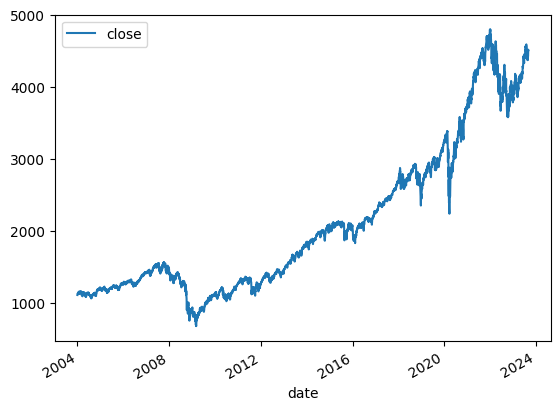

In [11]:
# plot prices
sp500.plot.line(y="close", use_index = True)


>Nie wydaje się, aby dane wykazały jakąkolwiek zauważalną sezonowość w poszczególnych latach. Zamiast tego pokazuje trend wzrostowy, a nie zachowanie cykliczne. Można zauważyć też kilka większych spadków. W 2008 r. spadek spowodowany przez światowy kryzys. Na początku 2020 r. zauważalny spadek cen był związany z pandemią Covid-19. Ostatni widoczny spadek był widoczny w 2022 r.. Ogólnie widać bardzo duży wzrost w wartości indeksu w przeciągu niecałych 20 lat.


Text(0.5, 1.0, 'Volume')

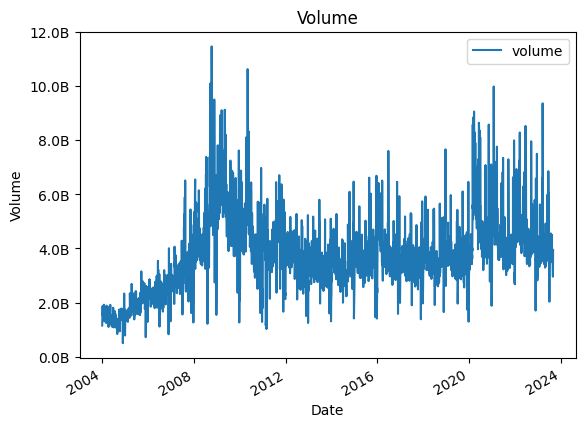

In [12]:
# plot volume
volume_plot = sp500.plot.line(y="volume", use_index = True)
volume_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%1.1fB' % (x * 1e-9)))
volume_plot.set_xlabel("Date")
volume_plot.set_ylabel("Volume")
volume_plot.set_title('Volume')

>Wykres wykazuje znaczny szum wynikający z zastosowania skali dziennej. Wybierając średni miesięczny wolumen obrotu, a nie dzienny wolumen obrotu, oczekuje się, że wynikowa wizualizacja będzie bardziej zrozumiała i atrakcyjna wizualnie.

Text(0.5, 1.0, 'Average monthly volume')

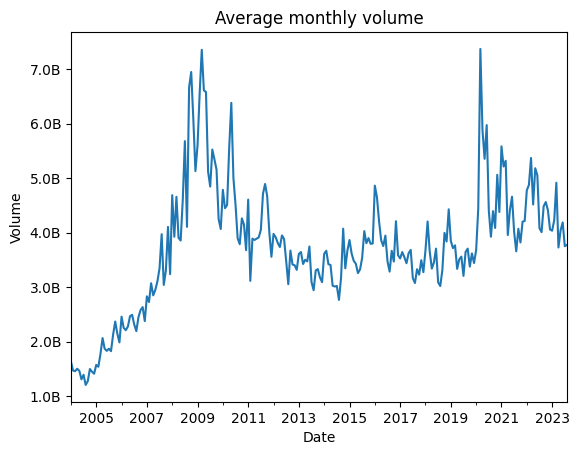

In [13]:
# plot of average monthly volume
sp500_volume = sp500['volume'].copy()
sp500_volume = sp500_volume.resample('1M').mean()
volume_plot_avg_m= sp500_volume.plot.line(y="volume", use_index = True)
volume_plot_avg_m.set_xlabel("Date")
volume_plot_avg_m.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '%1.1fB' % (x * 1e-9)))
volume_plot_avg_m.set_ylabel("Volume")
volume_plot_avg_m.set_title('Average monthly volume')

>Wykres jest dużo bardziej czytelny dzięki zwiększeniu interwału pomiędzy poszczególnymi danymi do miesiąca. Widać na tym wykresie początkowy trend wzrostowy, a później ustabilizowanie ilości wolumenu w obrocie. Są dwa widoczne okresy większych obrotów w okolicy kryzysu z 2008 r. oraz początku pandemii Covid-19.

In [14]:
# seasonality
sp500_copy = sp500.copy()
sp500_copy['year'] = sp500_copy.index.year
sp500_copy['month'] = sp500_copy.index.month
print(sp500_copy['year'].unique())
sp500_copy

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]


,open,high,low,close,volume,dividends,stock splits,year,month
date,,,,,,,,,
2004-01-02 00:00:00-05:00,1111.920044,1118.849976,1105.079956,1108.479980,1153200000,0.0,0.0,2004,1
2004-01-05 00:00:00-05:00,1108.479980,1122.219971,1108.479980,1122.219971,1578200000,0.0,0.0,2004,1
2004-01-06 00:00:00-05:00,1122.219971,1124.459961,1118.439941,1123.670044,1494500000,0.0,0.0,2004,1
2004-01-07 00:00:00-05:00,1123.670044,1126.329956,1116.449951,1126.329956,1704900000,0.0,0.0,2004,1
2004-01-08 00:00:00-05:00,1126.329956,1131.920044,1124.910034,1131.920044,1868400000,0.0,0.0,2004,1
...,...,...,...,...,...,...,...,...,...
2023-08-25 00:00:00-04:00,4389.379883,4418.459961,4356.290039,4405.709961,3296180000,0.0,0.0,2023,8
2023-08-28 00:00:00-04:00,4426.029785,4439.560059,4414.979980,4433.310059,2957230000,0.0,0.0,2023,8
2023-08-29 00:00:00-04:00,4432.750000,4500.140137,4431.680176,4497.629883,3354820000,0.0,0.0,2023,8


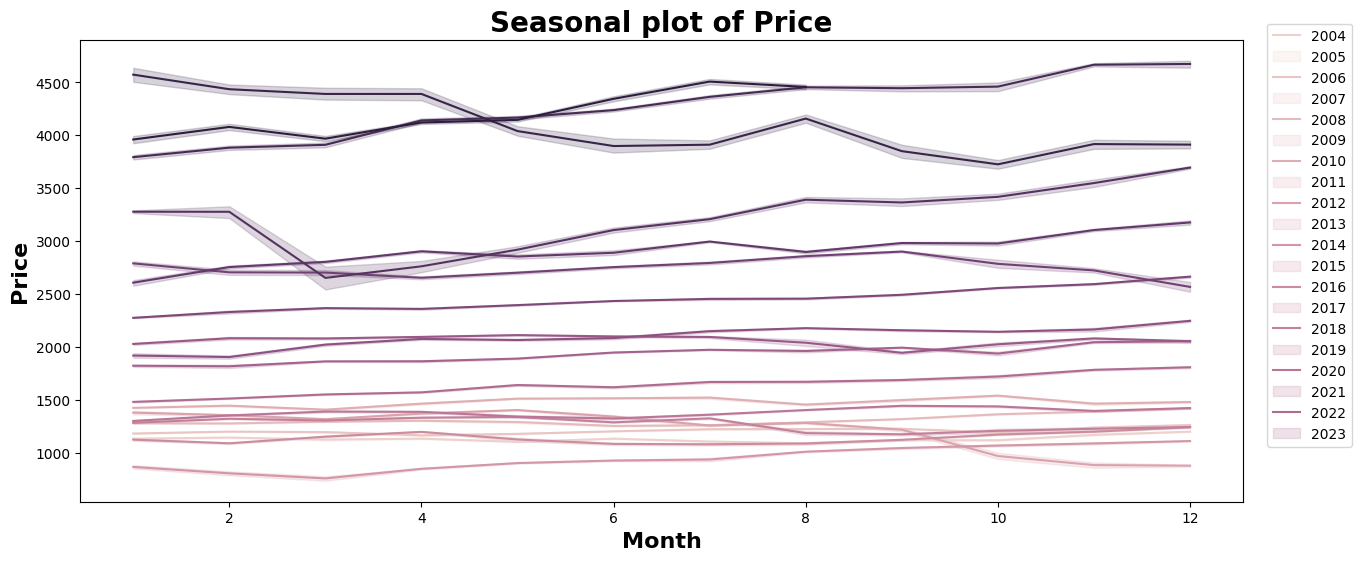

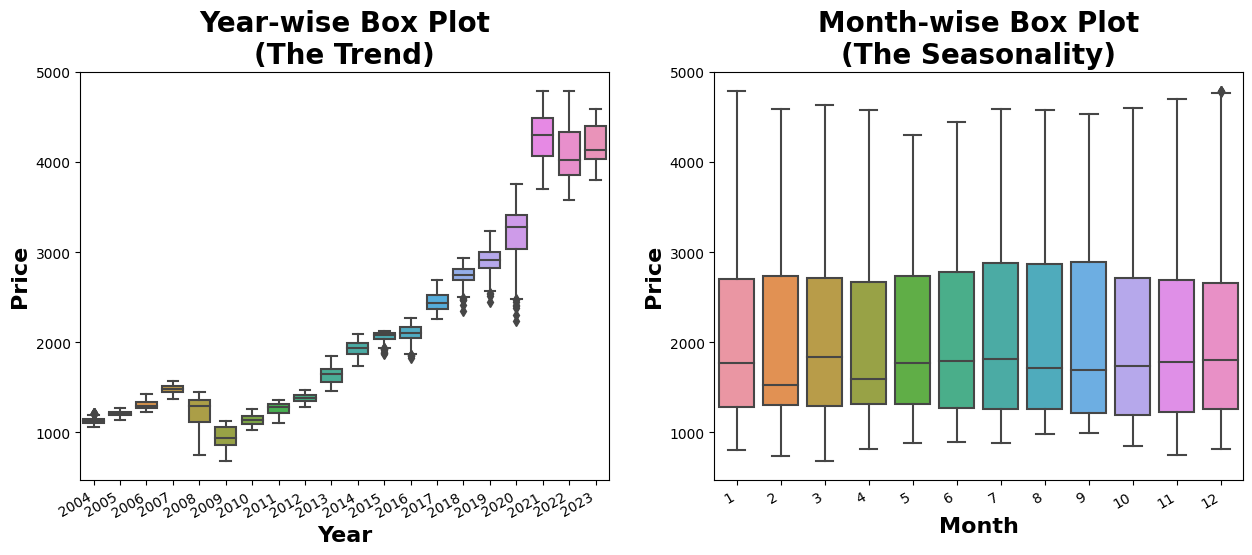

In [15]:
# seasonality of price column
column = "close"
# create a figure with one plot
fig_seasonal, ax = plt.subplots(figsize=(15, 6))

# plot the seasonal line plot
sns.lineplot(x=sp500_copy['month'], y=sp500_copy[column], hue = sp500_copy['year'])

# format the plot
ax.set_title('Seasonal plot of Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2004+i) for i in range(20)], bbox_to_anchor=(1.1, 1.05))

# create a figure with two plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# plot the year-wise box plot
sns.boxplot(x=sp500_copy['year'], y=sp500_copy[column], ax=ax[0])

# format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# plot the month-wise box plot
sns.boxplot(x=sp500_copy['month'], y=sp500_copy[column], ax=ax[1])

# format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))

# rotate the x-axis labels for better readability
fig.autofmt_xdate()

**Seasonal plot of Price**

>Dla poszczególnych lat nie widać wyraźniej sezonowości. Chociaż można zauważyć większą zmienność notowań dla ostatnich lat.

**Year wise Box Plot**

>Na tym wykresie widać ogólny trend wzrostowy. Nie jest widoczna sezonowość. Natomiast można zauważyć znaczne wartości odstające dla 2008 r. oraz ostatnich lat. To sugeruje większą zmienność w tych okresach. Co jest związane z większą niepewnością inwestorów na rynku w tych okresach. Dla reszty notowań wartości są dosyć mocno ograniczone w wąskim zakresie.

**Month wise Box Plot**

>Nie są widoczne dużej rozbieżności. Można jednak zauważyć, że mediana dla lutego oraz kwietnia jest troszkę niższa od pozostałych miesięcy.

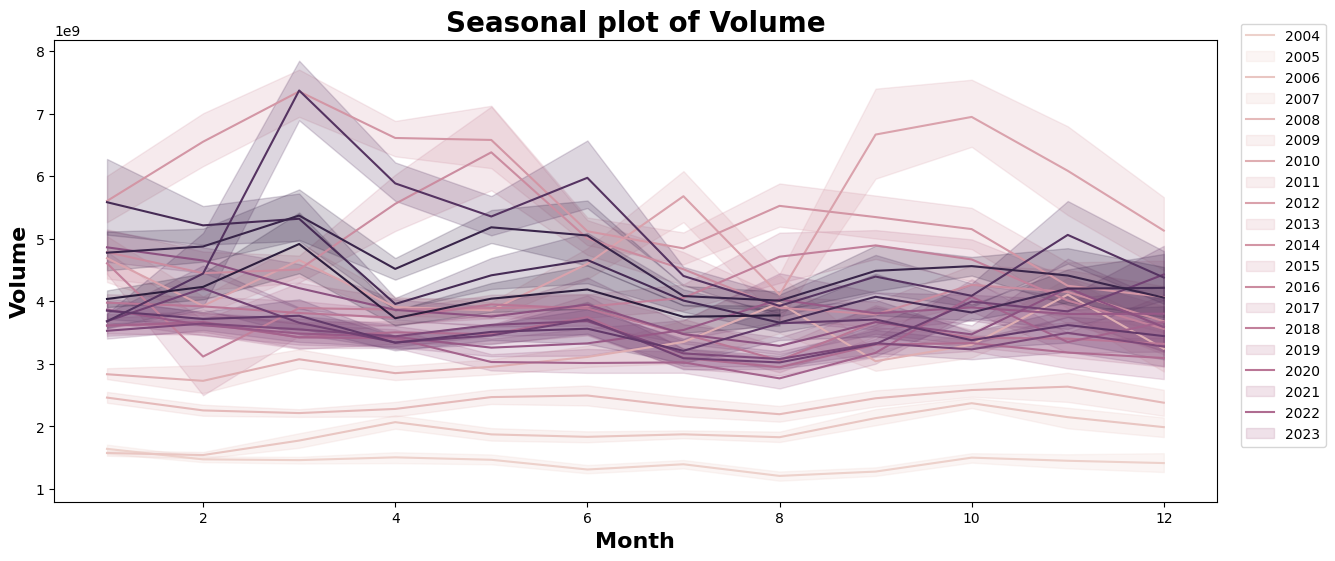

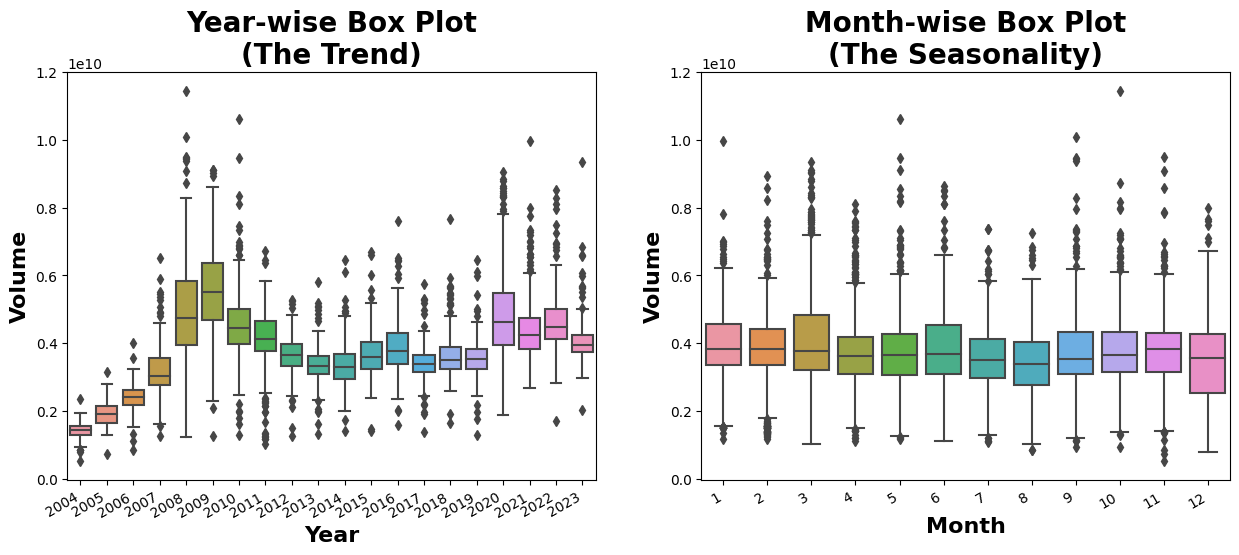

In [16]:
# seasonality of volume column
column = "volume"
# create a figure with one plot
_, ax = plt.subplots(figsize=(15, 6))

# plot the seasonal line plot
sns.lineplot(x=sp500_copy['month'], y=sp500_copy[column], hue = sp500_copy['year'])

# format the plot
ax.set_title('Seasonal plot of Volume', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Volume', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2004+i) for i in range(20)], bbox_to_anchor=(1.1, 1.05))

# create a figure with two plots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# plot the year-wise box plot
sns.boxplot(x=sp500_copy['year'], y=sp500_copy[column], ax=ax[0])

# format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Volume', fontsize = 16, fontdict=dict(weight='bold'))

# plot the month-wise box plot
sns.boxplot(x=sp500_copy['month'], y=sp500_copy[column], ax=ax[1])

# format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Volume', fontsize = 16, fontdict=dict(weight='bold'))

# rotate the x-axis labels for better readability
fig.autofmt_xdate()

**Seasonal plot of Volume**

>Dla poszczególnych lat nie widać wyraźniej sezonowości. Można zauważyć mniejszą ilość wolumenu dla miesięcy letnich, czyli lipca i sierpnia.

**Year wise Box Plot**

>Na tym wykresie jest widoczny początkowy z największą medianą dla roku 2009. Następnie ilość wolumenu w obiegu spada i stabilizuje w ostatnich latach. Największa zmienność jest dla lat związanych z większymi spadkami notowań. To zapewne wynika z większej dynamiki cen oraz nerwowości inwestorów. Znaczne wartości odstające pojawiają się od roku 2007.  Wskazują większą zmienność wolumenu, która stale się utrzymuje.

**Month wise Box Plot**

>Nie są widoczne dużej rozbieżności. Nie można stwierdzić istniejącej sezonowości

Text(0, 0.5, 'Volume')

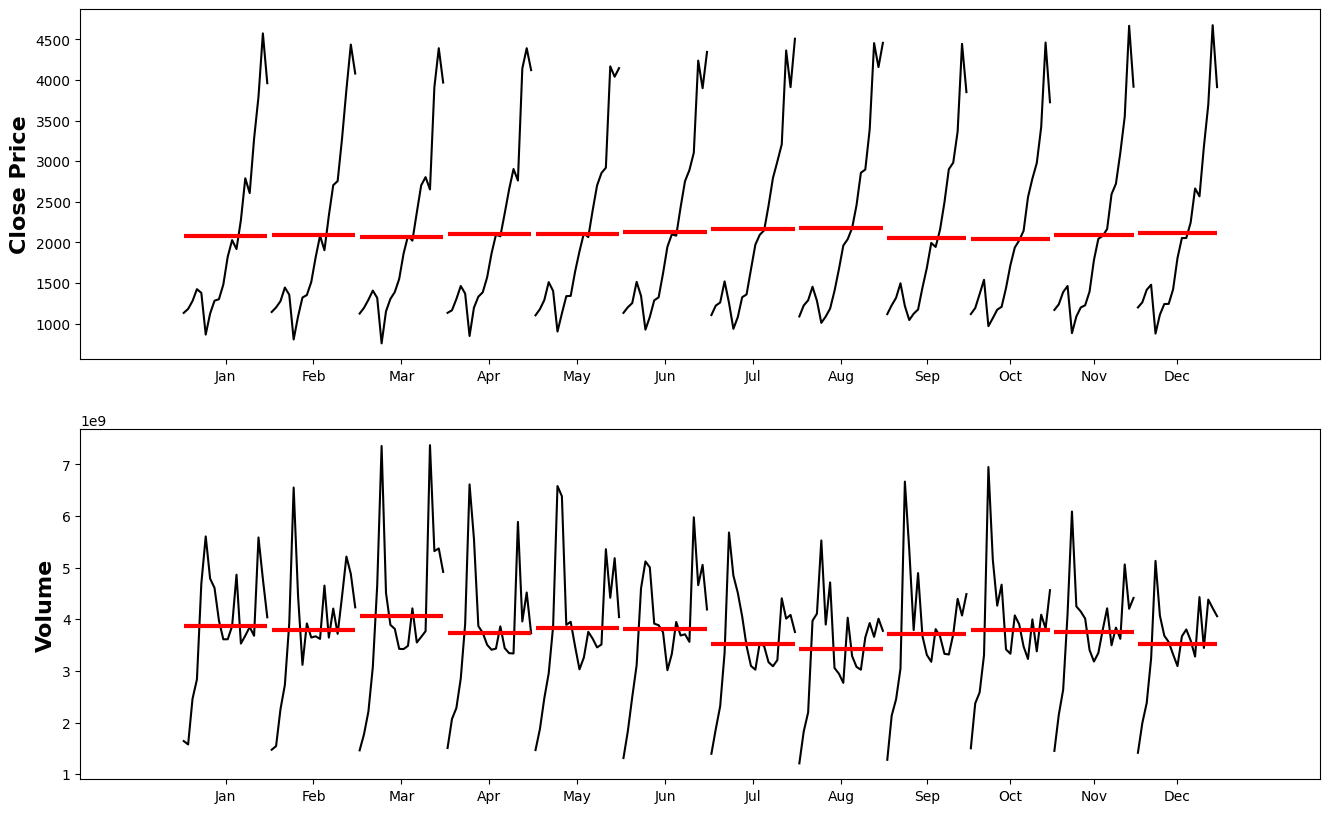

In [17]:
# aggregating sp500 stock quotes to a monthly scaled index
sp500_month_agg = sp500.resample('1M').mean()

# Create the seasonal subseries plots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

month_plot(sp500_month_agg['close'], ax=ax[0])
ax[0].set_ylabel('Close Price', fontsize = 16, fontdict=dict(weight='bold'))

month_plot(sp500_month_agg['volume'], ax=ax[1])
ax[1].set_ylabel('Volume', fontsize = 16, fontdict=dict(weight='bold'))

>Wykresy te agregują wartości ze wszystkich lat dla poszczególnych miesięcy. Dzięki temu można potencjalnie zauważyć wyraźniejszy obraz potencjalnej miesięcznej sezonowości.
>
>Staje się oczywiste, że nie ma sezonowości dla notowań. Średnia miesięcznych wartości notowań dla S&P 500 pozostaje stosunkowo stała.
>
>Dla wolumenu jest widoczna większa zmienność, ale nie jest duża. Średnia miesięcznych ilości obrotów na indeksie S&P 500 różni się nieznacznie dla poszczególnych miesięcy. Widoczne są mniejsze wartości dla miesięcy letnich.

**<font color="#5963ab" size="4">nyt_hl</font>**

>New York Times jest jednym z najbardziej wpływowych i rozpoznawalnych dzienników w Stanach Zjednoczonych i na całym świecie. Jest to amerykańska gazeta z siedzibą w Nowym Jorku, znana ze wszechstronnego relacjonowania wiadomości krajowych i międzynarodowych, polityki, biznesu, kultury i wielu innych tematów. Dlatego analiza nagłówków może dawać wskazówki o sytuacji geopolitycznej i ekonomicznej na świecie, co może uda się z powodzeniem wykorzystać do predykcji notowań.

In [18]:
# check for missing values in each column
missing_columns = nyt_hl.isnull().sum()
pprint("Missing values in column")
pprint(missing_columns)
print()
# print all problematic rows
null_mask = nyt_hl.isnull().any(axis=1)
null_rows = nyt_hl[null_mask]
pprint("Null rows")
pprint(null_rows)
print()
# delete null rows
nyt_hl = nyt_hl.dropna()

'Missing values in column'
headline    562
dtype: int64

'Null rows'
                          headline
date                              
2004-01-18 00:00:00-05:00      NaN
2004-02-08 00:00:00-05:00      NaN
2004-02-10 00:00:00-05:00      NaN
2004-02-22 00:00:00-05:00      NaN
2004-02-23 00:00:00-05:00      NaN
...                            ...
2022-01-20 00:00:00-05:00      NaN
2022-01-20 00:00:00-05:00      NaN
2022-10-14 00:00:00-04:00      NaN
2022-10-28 00:00:00-04:00      NaN
2022-10-28 00:00:00-04:00      NaN

[562 rows x 1 columns]



In [19]:
# group all articles for dates to lists
nyt_hl= nyt_hl.groupby(nyt_hl.index).agg({'headline': list})
nyt_hl

,headline
date,
2004-01-01 00:00:00-05:00,[FreeMarkets Agrees to Buy Auction Unit of Cov...
2004-01-02 00:00:00-05:00,"[Homeless in America, Yes, Today, Tony Cragg, ..."
2004-01-03 00:00:00-05:00,"[AIMING TO MAKE FASTER CHIPS, AGERE ACQUIRES T..."
2004-01-04 00:00:00-05:00,"[Wanted: Young Delegates, Corrections, How to ..."
2004-01-05 00:00:00-05:00,"[Cowboys Preparing To Take Next Step, Paid Not..."
...,...
2023-08-27 00:00:00-04:00,"[Flashback: Your Weekly History Quiz, August 2..."
2023-08-28 00:00:00-04:00,[Man Accused of Injecting Substance Into Neigh...
2023-08-29 00:00:00-04:00,[President of Powerful Realtors’ Group Resigns...


In [20]:
# print all nyt_hl data info
pprint(nyt_hl.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7182 entries, 2004-01-01 00:00:00-05:00 to 2023-08-31 00:00:00-04:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  7182 non-null   object
dtypes: object(1)
memory usage: 112.2+ KB
None


In [22]:
# sum articles for specific date
nyt_hl['art_amount'] = nyt_hl['headline'].str.len()
nyt_hl

,headline,art_amount
date,,
2004-01-01 00:00:00-05:00,[FreeMarkets Agrees to Buy Auction Unit of Cov...,224
2004-01-02 00:00:00-05:00,"[Homeless in America, Yes, Today, Tony Cragg, ...",70
2004-01-03 00:00:00-05:00,"[AIMING TO MAKE FASTER CHIPS, AGERE ACQUIRES T...",158
2004-01-04 00:00:00-05:00,"[Wanted: Young Delegates, Corrections, How to ...",516
2004-01-05 00:00:00-05:00,"[Cowboys Preparing To Take Next Step, Paid Not...",182
...,...,...
2023-08-27 00:00:00-04:00,"[Flashback: Your Weekly History Quiz, August 2...",63
2023-08-28 00:00:00-04:00,[Man Accused of Injecting Substance Into Neigh...,120
2023-08-29 00:00:00-04:00,[President of Powerful Realtors’ Group Resigns...,135


Text(0.5, 1.0, 'Average monthly published articles')

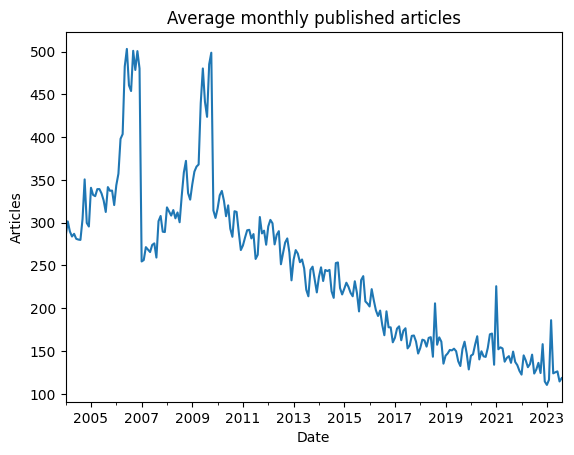

In [23]:
# plot of average monthly amount of published articles 
nyt_hl_sum = nyt_hl['art_amount'].copy()
nyt_hl_sum = nyt_hl_sum.resample('1M').mean()
art_avg_m= nyt_hl_sum.plot.line( use_index = True)
art_avg_m.set_xlabel("Date")
art_avg_m.set_ylabel("Articles")
art_avg_m.set_title('Average monthly published articles')

> Z powyższego wykresu widać niestety duży trend spadkowy w ilości publikowanych artykułów przez NYT. Są też dwa okresy zwiększonej ilości publikacji. Niestety nie jest to dobrą wiadomością dla wyznaczenia predykcji inwestowania. Nierównomierne rozłożenie danych w czasie, czyli ich niezbalansowanie to istotny problem. Ma on wpływ na skuteczność modeli uczenia maszynowego i może prowadzić do niepożądanych efektów.

In [24]:
# count words for all dates
def count_words(text_list):
    amount = 0
    for text in text_list:
        amount+= len(text.split())
    return amount

nyt_hl['word_count'] = nyt_hl['headline'].apply(count_words)
nyt_hl

,headline,art_amount,word_count
date,,,
2004-01-01 00:00:00-05:00,[FreeMarkets Agrees to Buy Auction Unit of Cov...,224,1529
2004-01-02 00:00:00-05:00,"[Homeless in America, Yes, Today, Tony Cragg, ...",70,433
2004-01-03 00:00:00-05:00,"[AIMING TO MAKE FASTER CHIPS, AGERE ACQUIRES T...",158,1000
2004-01-04 00:00:00-05:00,"[Wanted: Young Delegates, Corrections, How to ...",516,3001
2004-01-05 00:00:00-05:00,"[Cowboys Preparing To Take Next Step, Paid Not...",182,1244
...,...,...,...
2023-08-27 00:00:00-04:00,"[Flashback: Your Weekly History Quiz, August 2...",63,548
2023-08-28 00:00:00-04:00,[Man Accused of Injecting Substance Into Neigh...,120,1142
2023-08-29 00:00:00-04:00,[President of Powerful Realtors’ Group Resigns...,135,1271


Text(0.5, 1.0, 'Average monthly words in articles')

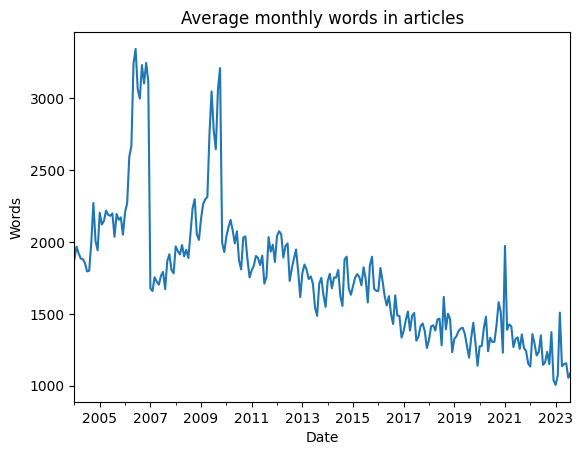

In [25]:
# plot of average monthly amount of published articles 
nyt_hl_sum = nyt_hl['word_count'].copy()
nyt_hl_sum = nyt_hl_sum.resample('1M').mean()
art_avg_m= nyt_hl_sum.plot.line( use_index = True)
art_avg_m.set_xlabel("Date")
art_avg_m.set_ylabel("Words")
art_avg_m.set_title('Average monthly words in articles')

> Powyższy wykres pokrywa się z poprzednim wykresem. Widać dużo większą ilość słów dla lat z pierwszych lat zebranych danych. 

In [26]:
# seasonality
nyt_hl_copy = nyt_hl.copy()
nyt_hl_copy['year'] = nyt_hl_copy.index.year
nyt_hl_copy['month'] = nyt_hl_copy.index.month
print(nyt_hl_copy['year'].unique())
nyt_hl_copy

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]


,headline,art_amount,word_count,year,month
date,,,,,
2004-01-01 00:00:00-05:00,[FreeMarkets Agrees to Buy Auction Unit of Cov...,224,1529,2004,1
2004-01-02 00:00:00-05:00,"[Homeless in America, Yes, Today, Tony Cragg, ...",70,433,2004,1
2004-01-03 00:00:00-05:00,"[AIMING TO MAKE FASTER CHIPS, AGERE ACQUIRES T...",158,1000,2004,1
2004-01-04 00:00:00-05:00,"[Wanted: Young Delegates, Corrections, How to ...",516,3001,2004,1
2004-01-05 00:00:00-05:00,"[Cowboys Preparing To Take Next Step, Paid Not...",182,1244,2004,1
...,...,...,...,...,...
2023-08-27 00:00:00-04:00,"[Flashback: Your Weekly History Quiz, August 2...",63,548,2023,8
2023-08-28 00:00:00-04:00,[Man Accused of Injecting Substance Into Neigh...,120,1142,2023,8
2023-08-29 00:00:00-04:00,[President of Powerful Realtors’ Group Resigns...,135,1271,2023,8


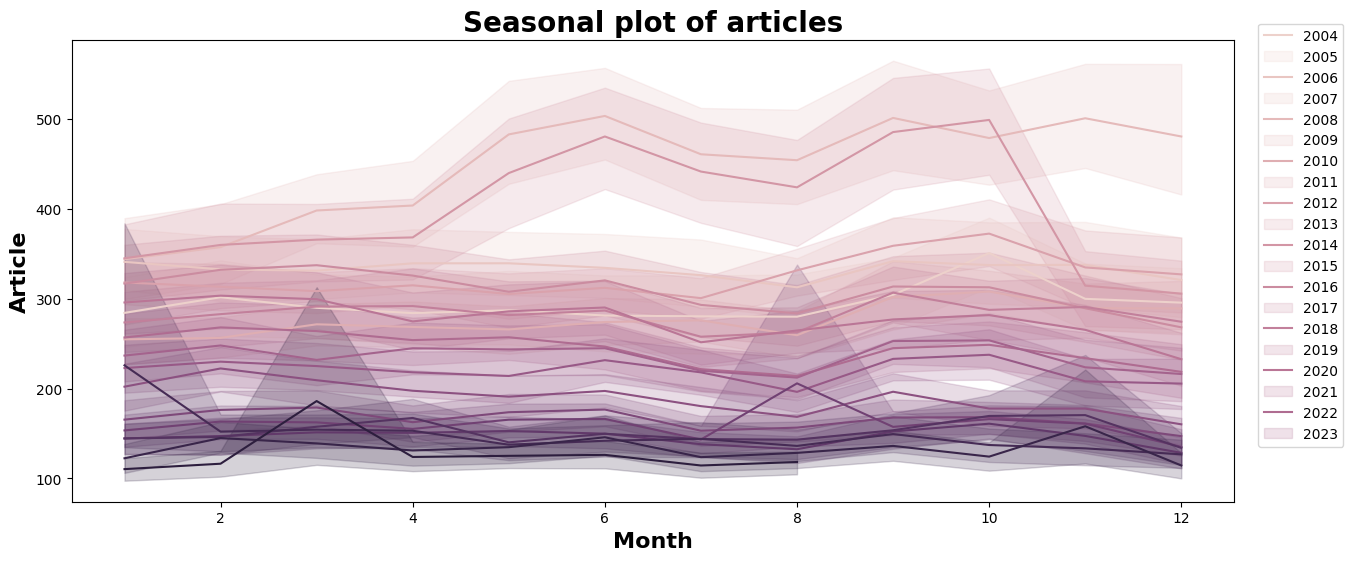

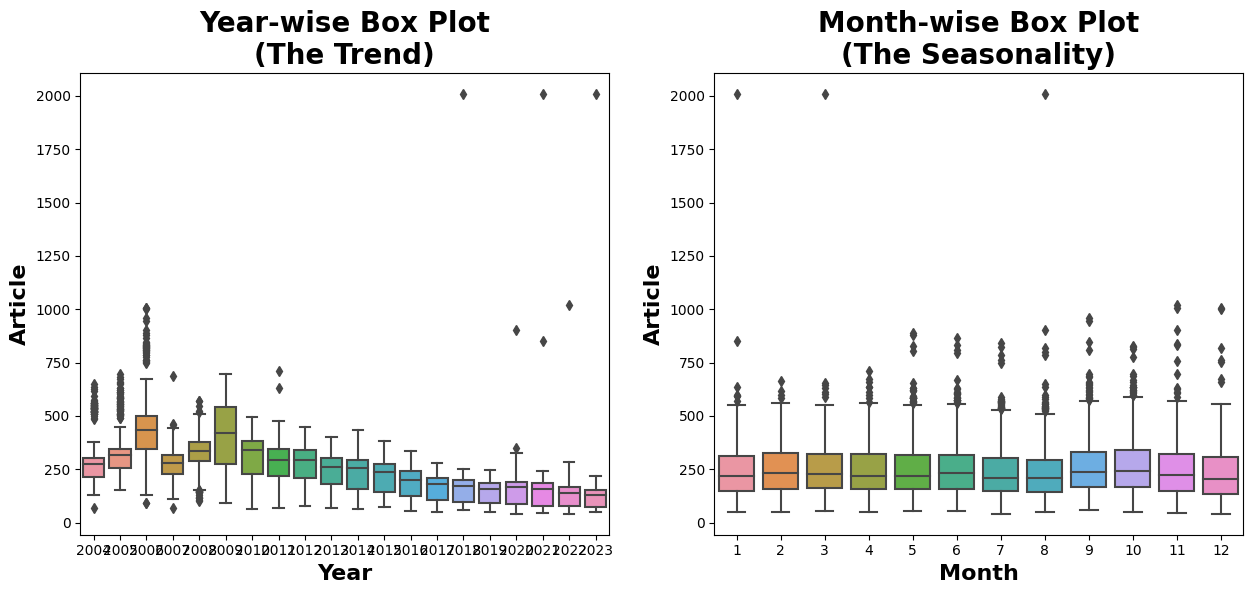

In [27]:
# seasonality of art_amount column
column = "art_amount"
# create a figure with one plot
_, ax = plt.subplots(figsize=(15, 6))

# plot the seasonal line plot
sns.lineplot(x=nyt_hl_copy['month'], y=nyt_hl_copy[column], hue = nyt_hl_copy['year'])

# format the plot
ax.set_title('Seasonal plot of articles', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Article', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2004+i) for i in range(20)], bbox_to_anchor=(1.1, 1.05))

# create a figure with two plots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# plot the year-wise box plot
sns.boxplot(x=nyt_hl_copy['year'], y=nyt_hl_copy[column], ax=ax[0])

# format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Article', fontsize = 16, fontdict=dict(weight='bold'))

# plot the month-wise box plot
sns.boxplot(x=nyt_hl_copy['month'], y=nyt_hl_copy[column], ax=ax[1])

# format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Article', fontsize = 16, fontdict=dict(weight='bold'))

# rotate the x-axis labels for better readability
fig.autofmt_xdate()

**Seasonal plot of Articles**

>Dla poszczególnych lat nie widać wyraźniej sezonowości. Można zauważyć inne wartości dla poszczególnych lat oraz większą zmienność dla lat z dużą ilością artykułów

**Year wise Box Plot**

>Na tym wykresie jest widoczny początkowy wzrost z największą medianą dla lat 2006 i 20009. Następnie ilość artykułów jest coraz mniejsza. Największa zmienność jest dla lat z największą ilością artykułów. Znaczne wartości odstające pojawiają się różnych okresach. W ostatnich latach widać dni, w których nadzwyczajnie było dużo publikacji, co jest zastanawiające, jak rzetelne są te dane pobrane z API NYT. Oznacza to, że trzeba je odpowiednio przetworzyć, aby użyć modelach.

**Month wise Box Plot** 

>Nie są widoczne dużej rozbieżności. Nie można stwierdzić istniejącej sezonowości

Text(0, 0.5, 'Words')

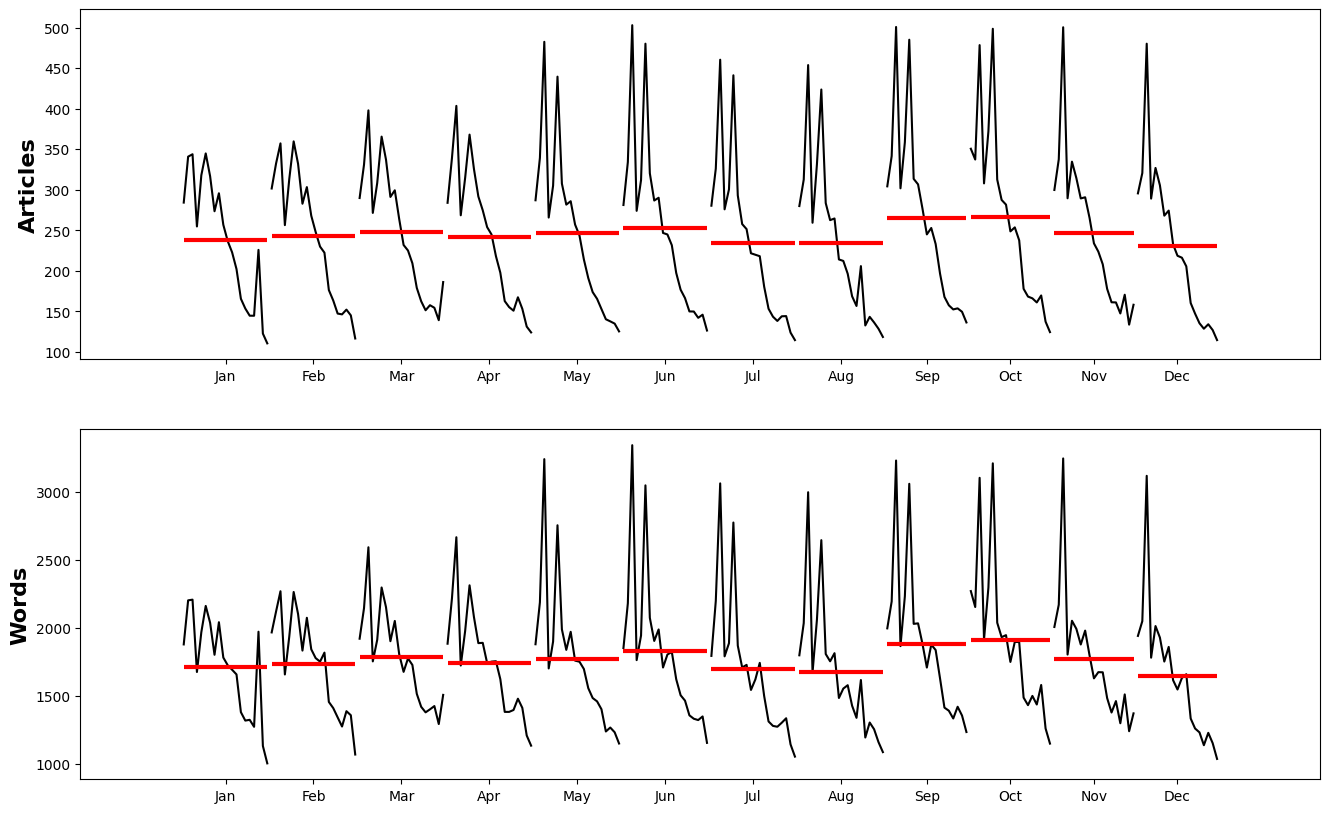

In [28]:
# aggregating nyt_hl to a monthly scaled index
nyt_hl_copy = nyt_hl.copy()
del nyt_hl_copy['headline']

nyt_hl_month_agg = nyt_hl_copy.resample('1M').mean()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

month_plot(nyt_hl_month_agg['art_amount'], ax=ax[0])
ax[0].set_ylabel('Articles', fontsize = 16, fontdict=dict(weight='bold'))

month_plot(nyt_hl_month_agg['word_count'], ax=ax[1])
ax[1].set_ylabel('Words', fontsize = 16, fontdict=dict(weight='bold'))

>Nie widać dużej zmienności dla poszczególnych miesięcy dla tych danych. Powoduje to, że nie ma sezonowości w ilości publikacji. Miesiące wakacyjne oraz grudzień mają nieznacznie niższą średnią.

**<font color="#5963ab" size="4">macro_data - sp500_rates</font>**

>Wskaźniki dla akcji, indeksów to liczby lub metryki, które pomagają inwestorom, analitykom finansowym i traderom ocenić stan rynku giełdowego, konkretnych akcji lub instrumentów finansowych. Istnieje wiele różnych wskaźników giełdowych, z których każdy koncentruje się na innych aspektach rynku.

In [29]:
# check for missing values in each column
missing_columns = sp500_rates.isnull().sum()
pprint("Missing values in column")
pprint(missing_columns)

# print all sp500_rates data info
print()
pprint(sp500_rates.info())

'Missing values in column'
pe                   0
cape                 0
earn_yield           0
pbv                  0
price_sales_ratio    0
div_yield            0
div_growth           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7183 entries, 2004-01-01 00:00:00-05:00 to 2023-08-31 00:00:00-04:00
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pe                 7183 non-null   float64
 1   cape               7183 non-null   float64
 2   earn_yield         7183 non-null   float64
 3   pbv                7183 non-null   float64
 4   price_sales_ratio  7183 non-null   float64
 5   div_yield          7183 non-null   float64
 6   div_growth         7183 non-null   float64
dtypes: float64(7)
memory usage: 448.9 KB
None


>**P/E Ratio** - (kolumna - 'pe')
>
>P/E (Price-to-Earnings ratio) to stosunek ceny akcji do zysku na akcje. Pomaga ocenić, które akcje są stosunkowo tanie (niski P/E), a które drogie (wysoki P/E).

Text(0.5, 1.0, 'P/E Ratio - S&P 500')

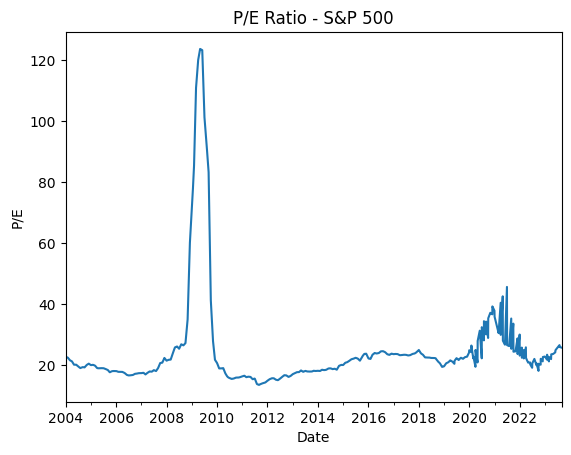

In [30]:
# plot P/E
sp500_pe_plot = sp500_rates['pe'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("P/E")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('P/E Ratio - S&P 500')

(10.0, 50.0)

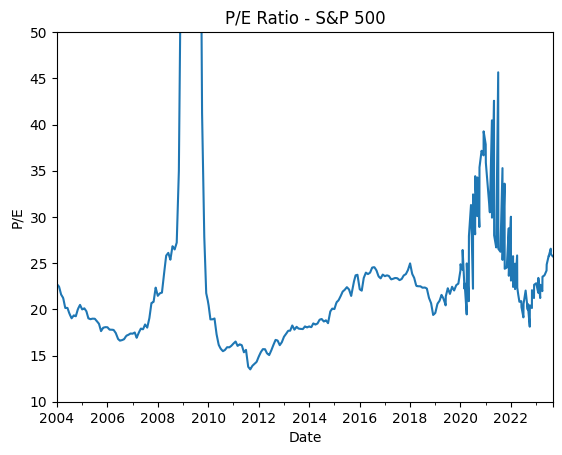

In [32]:
# plot P/E, set_ylim
sp500_pe_plot = sp500_rates['pe'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("P/E")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('P/E Ratio - S&P 500')
sp500_pe_plot.set_ylim(10, 50)

> Od razu rzuca się w oczy na wykresie Cena/Zysk duży pik w 2009 roku. Ten wystrzał w górę jest związany z osiąganiem niskich zysków przez firmy spowodowany kryzysem z 2008 r.. Dodatkowo w 2009 r. sytuacja się stabilizowała i wyceny spółek poszły do góry. Co spowodowało, aż taką wielkość tego współczynnika.  Wysokie wskaźniki P/E obserwowane w 2009 roku były odzwierciedleniem skrajnych warunków rynkowych w tym okresie. W miarę jak gospodarka wracała do wzrostu, a zyski spółek się poprawiały, wskaźniki P/E stopniowo się normalizowały. Wysokie wartości współczynnika dla tego okresu mówią, że P/E ma swoje wady. To jest ostrzeżeniem, że trzeba być uważnym w analizie i brać wiele danych, ponieważ dla specyficznych warunków niektóre wskaźniki zakłamują rzeczywistość.
>
>W okresie 2020 do 2022 widać dużą zmienność. Wskaźnik w tym okresie także osiągał duże wartości. Co także jest spowodowane wieloma czynnikami takimi jak pandemia czy polityka fiskalna i monetarna państw w tym szczególnie USA.

>**CAPE  Ratio** - (kolumna - 'cape')
>
>CAPE (Cyclically Adjusted Price-to-Earnings ratio) to wskaźnik służący ocenie wyceny akcji, który został opracowany przez laureata Nagrody Nobla, Roberta Schillera. Jest to miara, która uwzględnia inflację, cykl gospodarczy. Pomaga on ocenić czy akcje są w danym momencie przecenione, czy przewartościowane, pomagając inwestorom unikać przeszacowanych rynków.
>
>Wskaźnik ten porównuje aktualną cenę akcji do średniego zysku firmy na jedną akcję, skorygowanego o inflację, w ciągu ostatnich 10 lat. Główną ideą CAPE jest to, że przy użyciu wieloletniego przeciętnego zysku eliminuje się krótkoterminowe wahania cyklu gospodarczego. Wskaźnik ten pomaga inwestorom oceniać, jak rynki akcji są wyceniane na podstawie długoterminowych fundamentów.

Text(0.5, 1.0, 'CAPE Ratio - S&P 500')

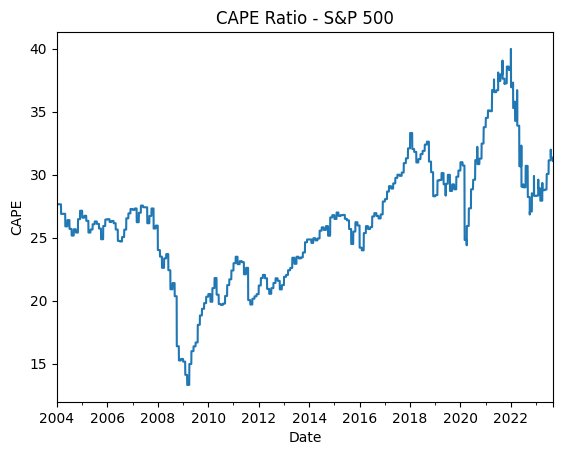

In [33]:
# plot CAPE
sp500_pe_plot = sp500_rates['cape'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("CAPE")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('CAPE Ratio - S&P 500')

> Nie ma tutaj jak w P/E bardzo gwałtownych zmian wartości. Dzięki wzięciu wyników finansowych z ostatnich 10 lat wykres jest bardziej odporny na krótkoterminowe wahania notowań. Minimum lokalne i globalne CAPE osiągał w czasach większych spadków indeksu. Swoje maksimum osiągnął na początku 2022 r., osiągając wartość około 40. Obecnie jego wartość wynosi ponad 30 i jest to dosyć znacznie powyżej średniej wartości.

>**Earning Yield** - (kolumna - 'earn_yield')
>
>Earnings Yield ratio to wskaźnik finansowy używany do oceny rentowności inwestycji w akcje lub spółki. Jest to stosunek zysku netto firmy do ceny jej akcji lub kapitalizacji rynkowej (wartości rynkowej spółki na giełdzie). Earnings Yield mierzy, ile procentowo zysku netto generowanego przez spółkę przypada na jedną jednostkę jej akcji. Wartość tego wskaźnika można interpretować podobnie jak wskaźnik P/E (Price-to-Earnings Ratio), ponieważ jest jego odwrotnością. Wskaźnik P/E mierzy, ile lat firma/indeks musi przynosić dany zysku netto, aby zwrócić wartość akcji. Podczas gdy Earnings Yield wyraża zysk netto jako procent ceny akcji.
>
>Earnings Yield może być przydatny w porównywaniu różnych spółek lub rynków giełdowych pod kątem potencjalnej rentowności inwestycji. Wyższy Earnings Yield oznacza, że inwestorzy mogą spodziewać się wyższej rentowności z inwestycji w akcje danej spółki/indeksu.

Text(0.5, 1.0, 'Earning Yield - S&P 500')

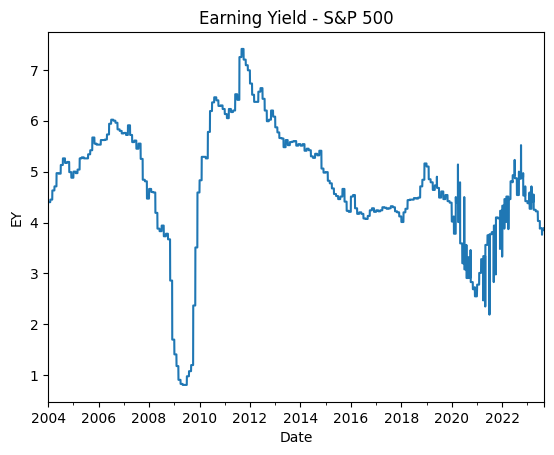

In [31]:
# plot Earning Yield
sp500_pe_plot = sp500_rates['earn_yield'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("EY")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('Earning Yield - S&P 500')

> Ten wskaźnik jest odwrotnością P/E, więc można wysunąć podobne wnioski. Widzimy, że obecnie EY nie jest zbyt wysoko, co oznacza, że rentowność nie jest duża w porównaniu do notowań historycznych.

>**PBV** - (kolumna - 'pbv')
>
>Wskaźnik PBV (Price-to-Book Value ratio) jest wskaźnikiem finansowym, który służy do oceny wyceny spółki na podstawie jej wartości księgowej. Jest to stosunek ceny rynkowej akcji spółki do jej wartości księgowej na jedną akcję.
>
>Niższy wskaźnik PBV może sugerować, że akcje są bardziej przystępne cenowo, podczas gdy wyższy wskaźnik może wskazywać na przewartościowanie. Wartości PBV poniżej 1 mogą sugerować, że akcje są wyceniane poniżej wartości księgowej. 

Text(0.5, 1.0, 'PBV - S&P 500')

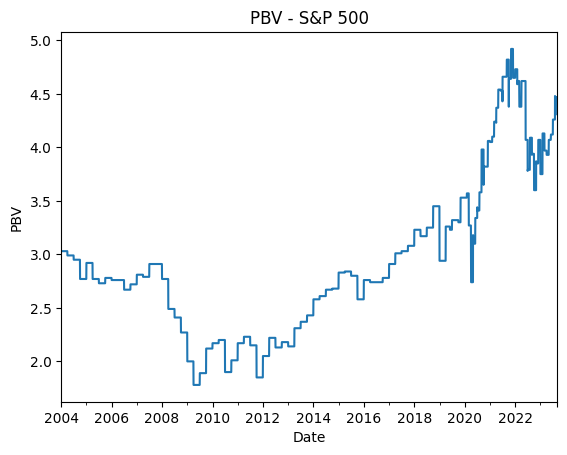

In [32]:
# plot Earning Yield
sp500_pe_plot = sp500_rates['pbv'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("PBV")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('PBV - S&P 500')

>Na wykresie widać, że w ostatnich 20 latach indeks dla 500 największych spółek USA miał wartość PBV dużo powyżej 1. Nie tak dawno osiągał swoje maksima, osiągając wartość prawie 5.
>
>Jednak wskaźnik PBV powinien być interpretowany w kontekście zmian, jakie zachodzą w gospodarce. Ponieważ różne branże mogą mieć różne typowe zakresy wartości PBV. Ostatnio coraz większe znaczenia mają firmy z branży technologicznej, a nie przemysłowej, które zazwyczaj posiadają mniej aktywów. Może to powodować większą wartość PBV. To jest dodatkowym minusem i oznacza, że dane wskaźniki mogą nie być użyteczne tak jak były w przeszłości i należy być uważnym w analizie i doborze jak najlepszych współczynników.

>**P/S Ratio** - (kolumna - 'prices_sales_ratio')
>
>Wskaźnik P/S (Price-to-Sales Ratio), nazywany również wskaźnikiem wyceny na podstawie przychodów, to wskaźnik finansowy wykorzystywany do oceny wyceny spółek. Jest to stosunek ceny akcji danej spółki do jej przychodów ze sprzedaży na jedną akcję lub na jednostkę udziałową.
>
> Niższy wskaźnik P/S może sugerować, że spółka jest bardziej przystępnie wyceniana w porównaniu do swoich przychodów, podczas gdy wyższy wskaźnik P/S może wskazywać na przewartościowanie lub oczekiwania rynku dotyczące przyszłego wzrostu przychodów.
Wskaźnik P/S jest szczególnie przydatny w analizie spółek, które generują duże przychody, ale niekoniecznie osiągają znaczne zyski netto. Jest on również często stosowany w analizie firm technologicznych oraz spółek z sektora wzrostowego, gdzie perspektywa wzrostu przychodów jest kluczowa.


Text(0.5, 1.0, 'P/S Ratio - S&P 500')

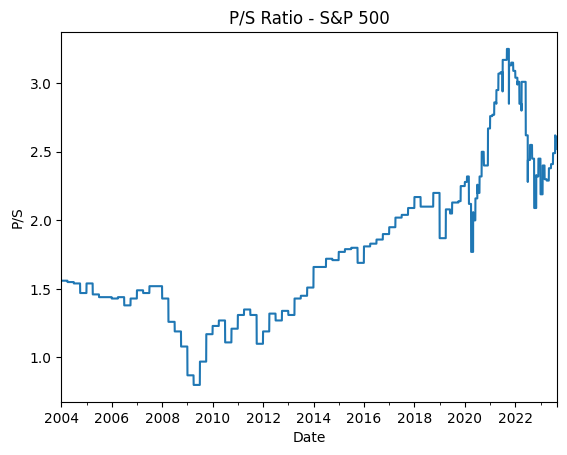

In [35]:
# plot P/S Ratio
sp500_pe_plot = sp500_rates['price_sales_ratio'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("P/S")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('P/S Ratio - S&P 500')

>Obecnie wartość P/S Ratio jest dosyć wysoka. Widać wyraźny trend wzrostowy z maksimum w 2021 r.. Minimum zostało osiągnięte w 2009 r..

>**Dividend Yield** - (kolumna - 'div_yield')
>
>Wskaźnik Dividend Yield (Stopa Dywidendy) to wskaźnik finansowy, który pomaga inwestorom ocenić stopę zwrotu z dywidend, jaką mogą uzyskać, inwestując w akcje danej spółki. Wyraża on procentowy stosunek rocznej dywidendy wypłacanej przez spółkę do jej aktualnej ceny akcji.
>
>Wskaźnik Dividend Yield informuje inwestorów o tym, ile procentowo dywidendy stanowią w stosunku do aktualnej wartości rynkowej akcji. Wyższy Dividend Yield oznacza, że inwestorzy mogą oczekiwać wyższej stopy zwrotu z dywidend w porównaniu do ceny akcji. Jest to szczególnie atrakcyjne dla inwestorów poszukujących stałego i stabilnego dochodu z inwestycji.
Jednak warto pamiętać, że wyższy Dividend Yield może być spowodowany przez niższą cenę akcji, co może wynikać z różnych czynników, w tym z niedocenienia spółki lub problemów finansowych. Dlatego inwestorzy powinni oceniać Dividend Yield w kontekście innych czynników, takich jak stabilność i wzrost dywidendy, zdolność spółki do generowania dochodu oraz ogólna sytuacja na rynku.

Text(0.5, 1.0, 'Dividend Yield - S&P 500')

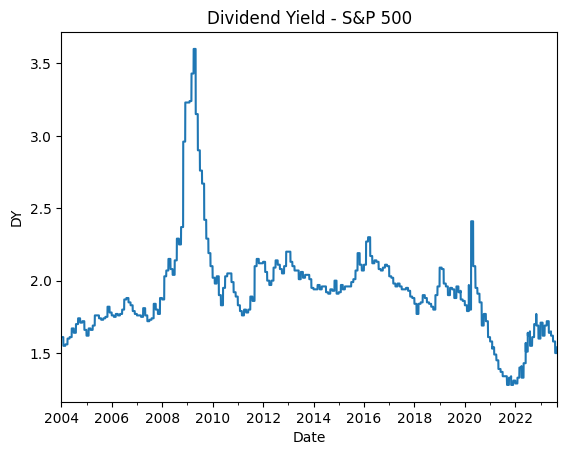

In [36]:
# plot Dividend Yield
sp500_pe_plot = sp500_rates['div_yield'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("DY")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('Dividend Yield - S&P 500')

>Największe wartości zwrot z dywidendy miał w czasie kryzysu z 2008 r. Najniższe wartości na przełomie 2021/2022 r.. Obecnie wartość nie jest za wysoka i wynosi około 1.5%.

>**Dividend Growth** - (kolumna - 'div_growth')
>
>Wskaźnik Dividend Growth (Wzrost Dywidendy) to wskaźnik finansowy mierzący tempo wzrostu dywidend wypłacanych przez spółkę, indeks w ciągu określonego okresu. Jest to wskaźnik często analizowany przez inwestorów, zwłaszcza tych, którzy poszukują inwestycji, które regularnie zwiększają swoje wypłaty dywidendowe. Wzrost dywidend dla spółki jest uważany za wskaźnik zdrowego i stabilnego zarządzania finansami spółki oraz może sugerować, że spółka ma perspektywy wzrostu.
>
>Wskaźnik Dividend Growth wyraża względny wzrost dywidendy jako procent. Wskaźnik Dividend Growth jest ważnym narzędziem dla inwestorów, ponieważ może świadczyć o zdolności spółki do generowania rosnącego dochodu dla swoich akcjonariuszy. Jednak warto zwrócić uwagę, że wzrost dywidendy może być wynikiem wielu czynników, w tym poprawy wyników finansowych, zysków spółki, a także polityki dywidendowej zarządu. Jednak w tym indeksie mamy 500 spółek więc pojedyncze specyficzne zachowania spółek nie mają tak dużej wagi i widzimy jak ogólnie cały rynek, prowadzi politykę dywidend.
>
>Wskaźnik tutaj jest obliczany kwartalnie. Czyli zmiana procentowa jest obliczana na podstawie wysokości dywidend z dwóch ostatnich kwartałów. Dzięki czemu będzie można zauważyć szybciej zmiany na rynku, ale może być więcej szumu, nagłych zmian.

Text(0.5, 1.0, 'Dividend Growth - S&P 500')

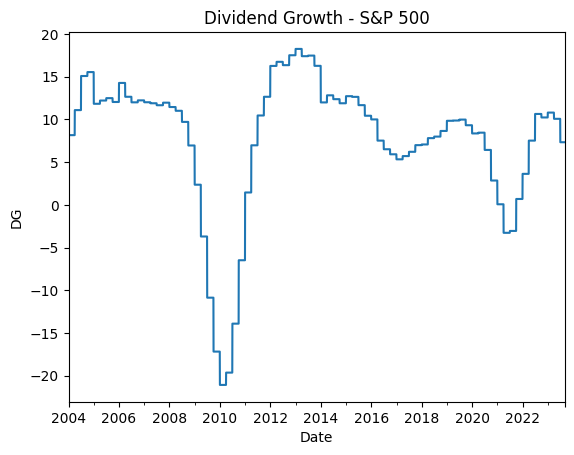

In [37]:
# plot Dividend Growth
sp500_pe_plot = sp500_rates['div_growth'].plot.line( use_index = True)
sp500_pe_plot.set_ylabel("DG")
sp500_pe_plot.set_xlabel("Date")
sp500_pe_plot.set_title('Dividend Growth - S&P 500')

>Na wykresie widać duży spadek dywidend dla okresów związanych z pogorszeniem sytuacji gospodarczej. Co wiąże się z mniejszymi zyskami w tym okresie, oraz mniejszą chęcią wypłacania dywidend. Obecnie wartość Dividend Growth wynosi 7,33%.

**<font color="#5963ab" size="4">macro_data - usa_eco_rates</font>**

>Wskaźniki makroekonomiczne to liczby i statystyki używane do pomiaru i analizy wydajności gospodarki na poziomie makroekonomicznym, czyli ogólnym. Te wskaźniki dostarczają informacji na temat kluczowych aspektów gospodarki danego kraju lub regionu i pozwalają na ocenę jej kondycji, trendów oraz zdolności do wzrostu. Wskaźniki makroekonomiczne są szeroko stosowane przez rządy, banki centralne, inwestorów i analityków do podejmowania decyzji i oceny polityki gospodarczej. 

In [38]:
# check for missing values in each column
missing_columns = usa_eco_rates.isnull().sum()
pprint("Missing values in column")
pprint(missing_columns)

# print all usa_eco_rates data info
print()
pprint(usa_eco_rates.info())

'Missing values in column'
gdp                         0
gdp_percent_change          0
unemploy_rate               0
pmi_index                   0
cpiaucsl_pch                0
fed_effective_rate          0
fed_effect_rate_pch         0
10usy_bond_yield            0
cons_sent                   0
cons_sent_percent_change    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7183 entries, 2004-01-01 00:00:00-05:00 to 2023-08-31 00:00:00-04:00
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gdp                       7183 non-null   float64
 1   gdp_percent_change        7183 non-null   float64
 2   unemploy_rate             7183 non-null   float64
 3   pmi_index                 7183 non-null   float64
 4   cpiaucsl_pch              7183 non-null   float64
 5   fed_effective_rate        7183 non-null   float64
 6   fed_effect_rate_pch       7183 non-null   float64
 7   10us

>**Gross domestic product (GDP)** - (kolumna - 'gdp')
>
>GDP, czyli PKB, Produkt Krajowy Brutto, to kluczowy wskaźnik makroekonomiczny, który mierzy ogólną wartość wszystkich dóbr i usług wytworzonych w danym kraju w określonym okresie, zwykle w ciągu roku. PKB jest używany do pomiaru wielkości i wydajności gospodarki danego kraju i stanowi ważny wskaźnik do analizy i oceny jej zdrowia ekonomicznego.

Text(0.5, 1.0, 'Gross domestic product')

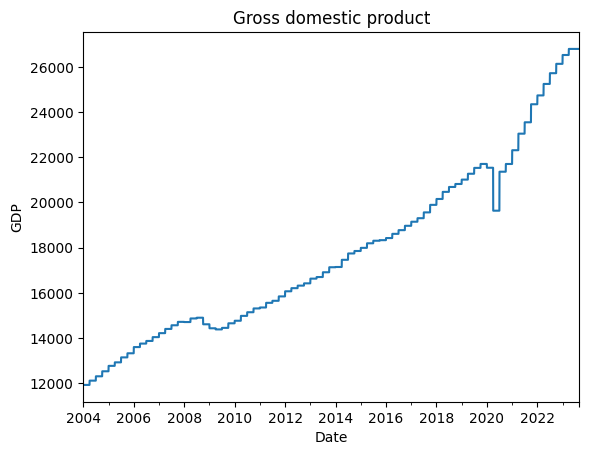

In [37]:
# plot Gross domestic product
usa_eco_rates_plot = usa_eco_rates['gdp'].plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("GDP")
usa_eco_rates_plot.set_xlabel("Date")
usa_eco_rates_plot.set_title('Gross domestic product')

>Widać duży trend wzrostowy, jeśli chodzi o PKB USA. Są zauważalne dwa spadki PKB związane z kryzysem w 2008 r. oraz z pandemią Covid-19. Jednak te spadki zostały z dużą nawiązką szybko odrobione.

>**GDP Percent Change** - (kolumna - 'gdp_percent_change')
>
>Zmiana procentowa PKB to wskaźnik używany do określenia zmiany ogólnej wartości Produktu Krajowego Brutto (PKB) w określonym okresie, wyrażonej jako procent. Ten wskaźnik jest ważnym narzędziem do monitorowania tempa wzrostu lub spadku gospodarki. Pozytywna zmiana procentowa oznacza wzrost gospodarczy, podczas gdy ujemna zmiana procentowa oznacza spadek gospodarczy.
>
>Zmiana procentowa PKB jest kluczowym wskaźnikiem do oceny tempa wzrostu gospodarczego lub recesji w danym kraju, lub regionie. Jest często używana przez analityków, inwestorów i ekonomistów do analizy kondycji gospodarczej i prognozowania przyszłych trendów gospodarczych.
>
>Wskaźnik tutaj jest obliczany kwartalnie. Czyli zmiana procentowa jest obliczana na podstawie wysokości PKB z dwóch ostatnich kwartałów. Dzięki czemu będzie można zauważyć szybciej zmiany na rynku, ale podobnie jak dla Dividend Growth może być więcej szumu i nagłych zmian.

Text(0.5, 1.0, 'GDP quartely percent change')

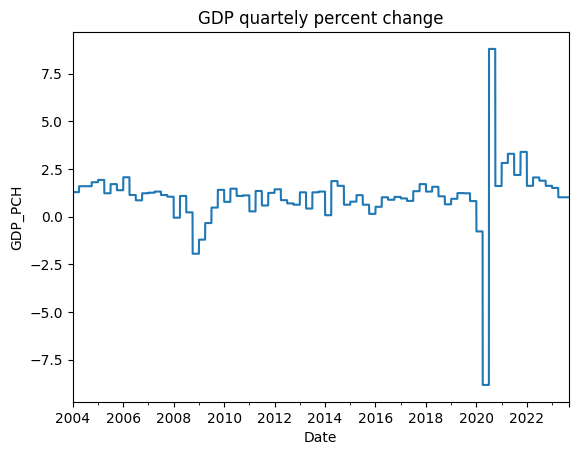

In [38]:
# plot GDP quarterly percent change
usa_eco_rates_plot = usa_eco_rates['gdp_percent_change'].plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("GDP_PCH")
usa_eco_rates_plot.set_xlabel("Date")
usa_eco_rates_plot.set_title('GDP quarterly percent change')

>Wykres prezentuje dość stabilny kilkuprocentowy kwartalny wzrost PKB gospodarki USA. W czasie kryzysu z 2008 r. widoczna jest recesja gospodarki. W czasie pandemii i spowodowanej przez nie lockdownu widoczna jest bardzo duża recesja, ale jest ona krótkotrwała i następuje po niej duże ożywienie gospodarki.

>**Unemployment rate** - (kolumna - 'unemploy_rate')
>
>Stopa bezrobocia to wskaźnik, który mierzy odsetek ludności aktywnej zawodowo, która jest bez pracy i aktywnie jej poszukuje w danym kraju w określonym okresie. Jest to jeden z kluczowych wskaźników rynku pracy i jest często używany do oceny zdrowia gospodarki oraz efektywności polityki rynku pracy.
>
> Im niższa jest stopa bezrobocia, tym bardziej korzystna jest sytuacja na rynku pracy. Ponieważ oznacza to, że większość osób jest zatrudniona. Natomiast wyższa stopa bezrobocia może świadczyć o trudnościach na rynku pracy i słabszym stanie gospodarki.

Text(0.5, 1.0, 'Unemployment rate')

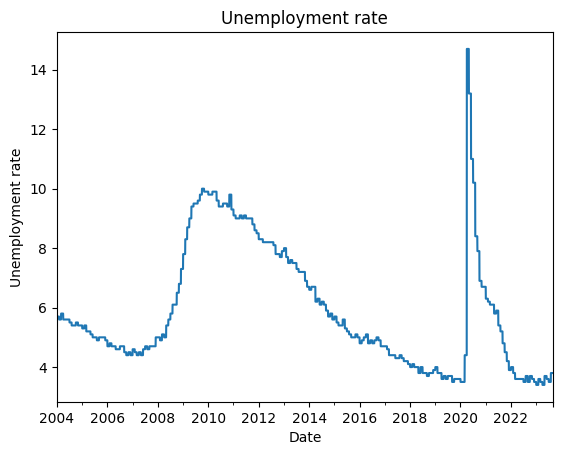

In [39]:
# plot Unemployment rate
usa_eco_rates_plot = usa_eco_rates['unemploy_rate'].plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("Unemployment rate")
usa_eco_rates_plot.set_xlabel("Date")
usa_eco_rates_plot.set_title('Unemployment rate')

>Wykres stopy bezrobocia w USA jest dość zmienny i prezentuje dwa wzrosty spowodowane recesją gospodarki. Widać, że w 2008 roku bezrobocie wzrastało nawet po kryzysie i miało dużą bezwładność. Zajęło kilka lat, aby powrócić do wartości 5% stopy bezrobocia po kryzysie. Natomiast dla pandemii, bardzo dynamiczny wzrost bezrobocia, także ma swoją bezwładność, ale został w miarę szybko zniwelowany. Obecnie amerykańska ma bardzo niskie bezrobocie wynoszące koło 3%.

>**Purchasing Managers' Index** - (kolumna - 'pmi_index')
>
>PMI (Purchasing Managers' Index) to indeks, który mierzy aktywność w sektorze produkcyjnym i usługowym gospodarki. Jest to ważny wskaźnik ekonomiczny używany do monitorowania wydajności gospodarki oraz oceny kierunku w jakim zmierza. Indeks PMI jest szeroko stosowany na całym świecie i dostarcza informacji na temat kondycji gospodarki oraz tendencji koniunkturalnych.
>
>Ogólna idea indeksu PMI polega na zbieraniu informacji od menedżerów odpowiedzialnych za zakupy (purchasing managers) w firmach. Menedżerowie ci są pytani o różne aspekty działalności swoich firm, takie jak liczba nowych zamówień, produkcja, zatrudnienie, poziom cen surowców itp.. Odpowiedzi te są następnie agregowane i przeliczane na wskaźnik PMI.
>Indeks PMI jest publikowany regularnie, zwykle co miesiąc, i stanowi ważne narzędzie analizy rynku. Jest używany w wielu krajach na całym świecie i pomaga w zrozumieniu zmian w aktywności gospodarczej oraz w podejmowaniu decyzji zarówno na rynkach finansowych, jak i w biznesie.

Text(0.5, 1.0, 'PMI Index')

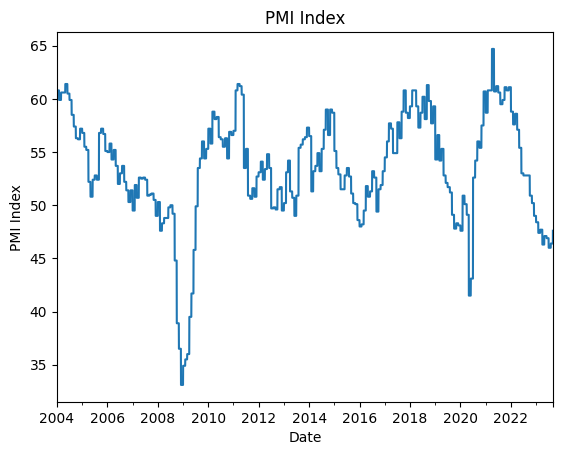

In [40]:
# plot PMI Index
usa_eco_rates_plot = usa_eco_rates['pmi_index'].plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("PMI Index")
usa_eco_rates_plot.set_xlabel("Date")
usa_eco_rates_plot.set_title('PMI Index')

>Duża zmienność jest widoczna na tym wykresie. Najniższe wartości notowane są w czasach recesji gospodarki USA. Obecnie wskaźnik w stosunku do ostatnich 20 lat jest nieznacznie poniżej 50, co jest niską wartością.

>**Consumer Price Index for All Urban Consumers** - (kolumna - 'cpiaucsl_pch')
>
>CPIAUCSL to skrót od "Consumer Price Index for All Urban Consumers". Jest to indeks cen konsumenckich obliczany w Stanach Zjednoczonych przez Biuro Statystyki Pracy (Bureau of Labor Statistics-BLS). Indeks CPIAUCSL jest używany do pomiaru zmian cen towarów i usług zakupowanych przez gospodarstwa domowe w obszarach miejskich w USA. Jest to jeden z głównych wskaźników inflacji i pomaga w monitorowaniu wzrostu cen na rynku konsumenckim.
>
>W kontekście indeksu CPI-U "percent change" (zmiana procentowa) odnosi się do procentowej zmiany wartości indeksu w określonym okresie. W tych danych wskaźnik jest liczony w każdy miesiąc do okresu wcześniejszego. Indeks PMI jest publikowany regularnie, zwykle co miesiąc, i stanowi ważne narzędzie analizy rynku. Jest to kluczowy wskaźnik ekonomiczny używany przez ekonomistów, banki centralne i rządy do analizy zdrowia gospodarki i podejmowania decyzji politycznych.

Text(0.5, 1.0, 'CPI monthly percent change')

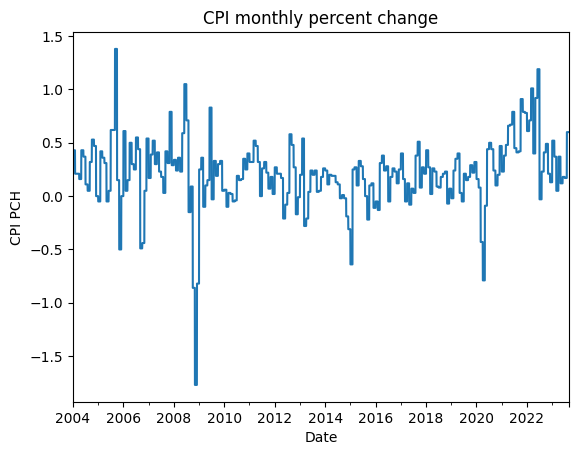

In [41]:
# plot Consumer Price Index for All Urban Consumers
usa_eco_rates_plot = usa_eco_rates['cpiaucsl_pch'].plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("CPI PCH")
usa_eco_rates_plot.set_xlabel("Date")
usa_eco_rates_plot.set_title('CPI monthly percent change')

>Z powodu częstego mierzenia tego indeksu widzimy dużą zmienność. W czasach recesji mamy deflację, szczególnie widoczną dla okresu z kryzysu 2008 r. Dla lat wzrostu gospodarczego indeks jest nieznacznie powyżej zera. W 2021 roku widać duży wzrost inflacji, która obecnie wydaje się ustabilizowana i wynosi 0,60% w stosunku do poprzedniego miesiąca.

>**Effective Federal Funds Rate (EFFR)** - (kolumna - 'fed_effective_rate')
>
>"Effective Federal Funds Rate" (EFFR), znana także jako "federal funds effective rate", to jedna z kluczowych stóp procentowych w Stanach Zjednoczonych. Jest to stopa procentowa, po której banki komercyjne udzielają sobie pożyczek na rynku międzybankowym, zwanych "federal funds market". EFFR jest jednym z głównych narzędzi, które Federal Reserve (Fed), amerykański bank centralny, używa do kontrolowania polityki monetarnej.
>
>EFFR jest kluczowym narzędziem, które pozwala Fed regulować poziom aktywności gospodarczej, kontrolować inflację i stabilizować rynki finansowe. Jest to ważny wskaźnik, który jest śledzony przez ekonomistów, inwestorów i instytucje finansowe, ponieważ jego zmiany mają bardzo duży wpływ na gospodarkę i rynki finansowe.

Text(0.5, 1.0, 'Effective Federal Funds Rate')

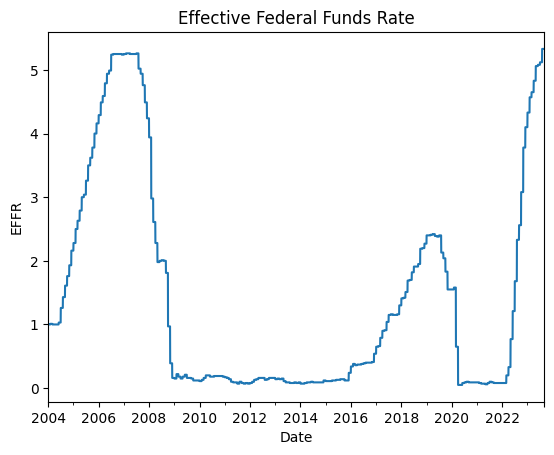

In [42]:
# plot Effective Federal Funds Rate
usa_eco_rates_plot = usa_eco_rates['fed_effective_rate'].plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("EFFR")
usa_eco_rates_plot.set_xlabel("Date")
usa_eco_rates_plot.set_title('Effective Federal Funds Rate')

>Na wykresie widać dwa duże wzrosty efektywnych stóp procentowych do wartości powyżej 5%. Włąsnie obeznie na takim poziomie są stopy procentowe, co jest spowodowane niedawną wysoką inflacją w USA. Można zauważyć, że przez długi okres stopy procentowe wynosiło koło 0%.

>**Effective Federal Funds Rate Percent Change** - (kolumna - 'fed_effective_rate_pch')
>
>Procentowa zmiana stopy "Effective Federal Funds Rate" (EFFR) odnosi się do procentowej zmiany tej stopy procentowej w określonym okresie. Procentowa zmiana w EFFR jest obliczana przez porównanie obecnej stopy do wcześniejszej stopy, zazwyczaj z miesiąca, kwartału lub roku wcześniej. Pomaga to ocenić, o ile procent stopa procentowa wzrosła lub spadła w tym okresie. W tych danych jest obliczana co miesiąc.
>
>Procentowa zmiana stopy "Effective Federal Funds Rate" jest istotnym wskaźnikiem służącym do analizowania tendencji w krótkoterminowych stopach procentowych w Stanach Zjednoczonych. Jest śledzona uważnie przez ekonomistów, decydentów politycznych i inwestorów, ponieważ może dostarczać informacji na temat stanowiska Federalnej Rezerwy w kwestii polityki pieniężnej oraz jej działań mających na celu kontrolowanie inflacji i wspieranie wzrostu gospodarczego.

Text(0.5, 1.0, 'Effective Federal Funds Rate Percent Change')

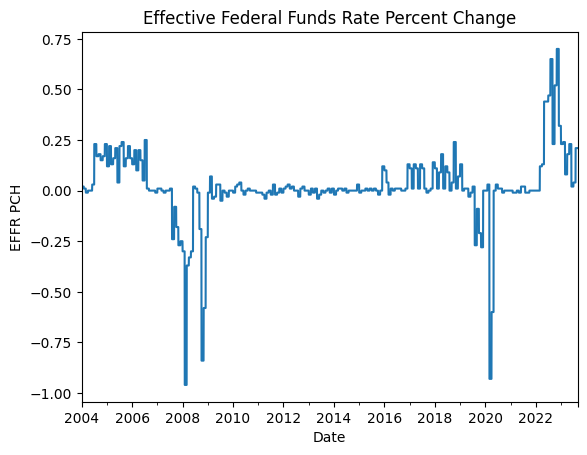

In [43]:
# plot Effective Federal Funds Rate Monthly Percent Change
usa_eco_rates_plot = usa_eco_rates['fed_effect_rate_pch'].plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("EFFR PCH")
usa_eco_rates_plot.set_xlabel("Date")
usa_eco_rates_plot.set_title('Effective Federal Funds Rate Percent Change')

>Na wykresie widać duże okresy stabilizacji efektywnych stóp procentowych. Jednak są widoczne trzy okresy-kryzys 2008, pandemia 2020, inflacja 2021, w których nastąpiły duże i częste zmiany stóp procentowych.

>**USA 10-Year Bond Yield** - (kolumna - '10usy_bond_yield')
>
>"USA 10-year bond yield" oznacza rentowność lub stopę procentową na 10-letnich obligacjach skarbowych Stanów Zjednoczonych. Reprezentuje to roczny zwrot, jaki inwestor może oczekiwać, trzymając 10-letnią obligację rządową Stanów Zjednoczonych do daty wykupu.
>
>Rentowność 10-letnich obligacji skarbowych USA to kluczowy wskaźnik finansowy, który odzwierciedla stopę procentową na 10-letnich obligacjach rządowych Stanów Zjednoczonych. Gra on istotną rolę na rynkach finansowych i pełni funkcję wskaźnika ekonomicznego, który odzwierciedla warunki gospodarcze i nastroje inwestorów.

Text(0.5, 1.0, 'USA 10-Year Bond Yield')

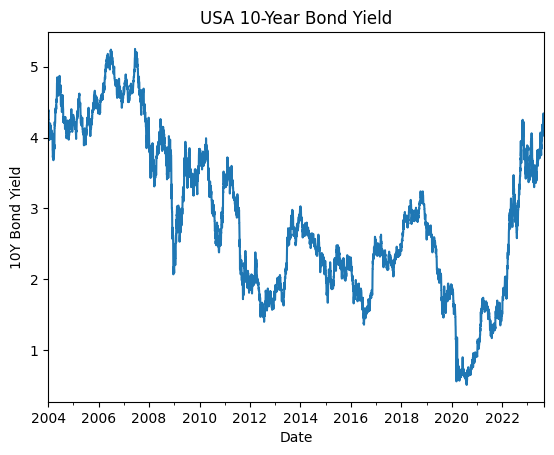

In [44]:
# plot USA 10-Year Bond Yield
usa_eco_rates_plot = usa_eco_rates['10usy_bond_yield'].plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("10Y Bond Yield")
usa_eco_rates_plot.set_xlabel("Date")
usa_eco_rates_plot.set_title('USA 10-Year Bond Yield')

>Ogólnie na wykresie jest widoczny trend spadkowy przez większość okresu. Od wartości powyżej 4%, rentowność 10-letnich obligacji spadła prawie do zera w 2020 r.. W ostatnich 2 latach widać odwrócenie trendu i duży szybki wzrost do wartości powyżej 4%.

>**Consumer Sentiment** - (kolumna - 'cons_sent')
>
>Jeden z popularnych wskaźników mierzących nastroje konsumentów w Stanach Zjednoczonych. Mierzony przez "University of Michigan Consumer Sentiment Index" (Indeks Nastrojów Konsumentów Uniwersytetu Michigan). "Consumer sentiment" odnosi się do ogólnego nastroju i postaw konsumentów wobec gospodarki, finansów osobistych oraz przyszłości. Jest to wskaźnik mierzący poziom pewności i optymizmu konsumentów, który może wpływać na ich decyzje zakupowe i wydatki.
>
>Indeks Nastrojów Konsumentów jest używany jako wskaźnik do analizy klimatu konsumenckiego i może dostarczać wskazówek dotyczących przyszłego zachowania rynku. Jest to również ważny element analizy ekonomicznej, który pomaga monitorować zmiany nastrojów konsumentów w odpowiedzi na zmieniające się warunki gospodarcze i wydarzenia na rynku.

Text(0.5, 1.0, 'Consumer Sentiment')

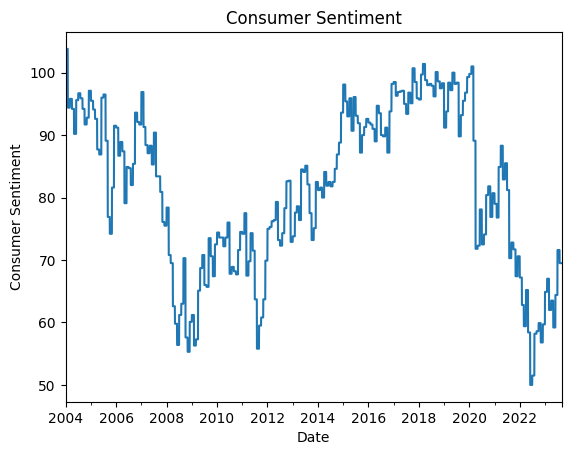

In [44]:
# plot Consumer Sentiment
usa_eco_rates_plot = usa_eco_rates['cons_sent'].plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("Consumer Sentiment")
usa_eco_rates_plot.set_xlabel("Date")
usa_eco_rates_plot.set_title('Consumer Sentiment')

>Im niższa wartość, tym gorsze nastroje konsumentów. Dlatego w czasach recesji gospodarki widoczne są najniższe wartości tego indeksu. Obecnie nastroje poprawiają się po pandemii Covid-19, ale patrząc na cały wykres, dalej nie są na wysokim poziomie.

>**Consumer Sentiment Percent Change** - (kolumna - 'cons_sent_percent_change')
>
>"Consumer sentiment percent change" dla Stanów Zjednoczonych odnosi się do procentowej zmiany wskaźnika nastrojów konsumentów (consumer sentiment) w danym okresie w porównaniu do poprzedniego okresu. Jest to miara, która informuje o tym, o ile procent wskaźnik nastrojów konsumentów wzrósł lub spadł w określonym czasie.
>
>Ten wskaźnik jest istotny, ponieważ pomaga analizować, czy nastroje konsumentów stają się bardziej optymistyczne (jeśli wartość jest dodatnia) lub bardziej pesymistyczne (jeśli wartość jest ujemna) w stosunku do wcześniejszego okresu. To może dostarczać informacji na temat zmian w postrzeganiu gospodarki i wpływać na decyzje konsumentów dotyczące zakupów i wydatków.
>
>Zmiany w nastrojach konsumentów są istotne dla ekonomistów, inwestorów i polityków, ponieważ mogą wpłynąć na zachowanie gospodarki, rynek pracy i inne aspekty ekonomiczne. Dlatego "Consumer sentiment percent change" jest śledzony i analizowany jako część badania nastrojów konsumentów.

Text(0.5, 1.0, 'Consumer Sentiment Monthly Percent Change')

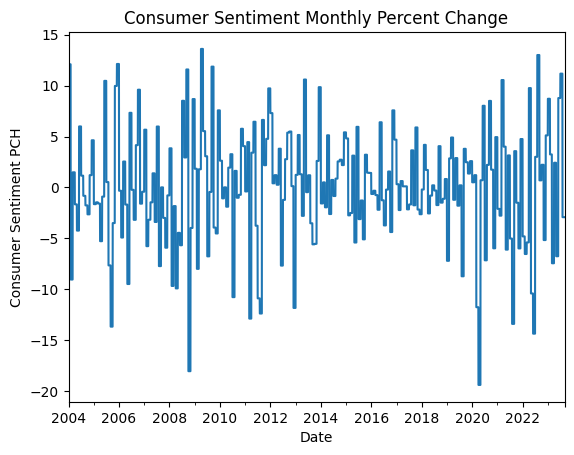

In [46]:
# plot Consumer Sentiment Monthly Percent Change
usa_eco_rates_plot = usa_eco_rates['cons_sent_percent_change'].plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("Consumer Sentiment PCH")
usa_eco_rates_plot.set_xlabel("Date")
usa_eco_rates_plot.set_title('Consumer Sentiment Monthly Percent Change')

>Widać dużą zmienność tego wykresu. Wykres jest bardzo trudny do odczytu. Ilość zmian powoduje, że trudno jest wyczytać coś z tego wykresu. Możliwe, że zwiększenie okresu porównywania wskaźnika do roku spowodowałoby większą czytelność i możliwość wysnucia ciekawych wniosków.

**<font color="#5963ab" size="4">goog_trend</font>**

>Google Trends to narzędzie dostarczane przez Google, które umożliwia analizowanie popularności i wyszukiwań określonych fraz lub słów kluczowych w wyszukiwarce Google w określonym czasie i w określonych regionach geograficznych. To narzędzie pozwala zrozumieć, jakie tematy są popularne w danym momencie oraz jak zmienia się ich popularność w czasie.
>
>Google Trends jest używane w różnych celach, takich jak analiza rynku, badanie trendów marketingowych, badanie zainteresowań społeczności online, śledzenie popularności produktów i wiele innych. Jest to przydatne narzędzie zarówno dla profesjonalistów w dziedzinie marketingu, jak i dla osób śledzących trendy w danym obszarze tematycznym.


In [45]:
# check for missing values in each column
missing_columns = goog_trend.isnull().sum()
pprint("Missing values in column")
pprint(missing_columns)
# print all goog_trend data info
print()
pprint(goog_trend.info())


'Missing values in column'
month_trend    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 236 entries, 2004-01-01 00:00:00-05:00 to 2023-08-01 00:00:00-04:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   month_trend  236 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB
None


Text(0.5, 1.0, 'S&P 500 trend')

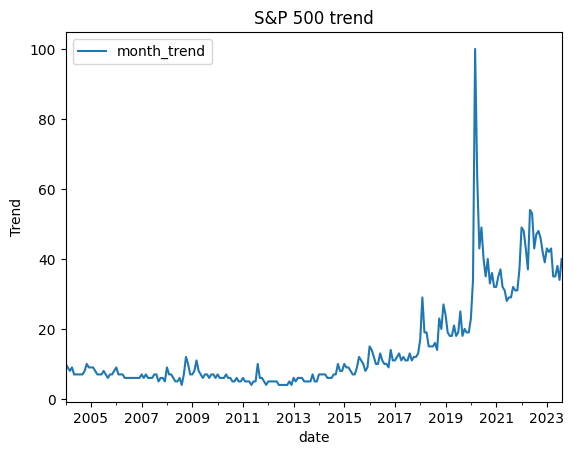

In [46]:
# plot trend
goog_trend_plot = goog_trend.plot.line( use_index = True)
goog_trend_plot.set_ylabel("Trend")
goog_trend_plot.set_title('S&P 500 trend')

>Z wykresu widać początkowo stabilną popularność wyszukiwań indeksu, ale od około roku 2015 następuje większa popularność. Szczyt równy 100 (trend jest mierzony w zakresie od 0 do 100) przypada w okresie wybuchu pandemii Covid-19.

In [47]:
# print date with max popularity
pprint(goog_trend.idxmax().max())
pprint(goog_trend.max().max())

Timestamp('2020-03-01 00:00:00-0500', tz='America/New_York')
100


In [48]:
# seasonality
goog_trend_copy = goog_trend.copy()
goog_trend_copy['year'] = goog_trend_copy.index.year
goog_trend_copy['month'] = goog_trend_copy.index.month
print(goog_trend_copy['year'].unique())
goog_trend_copy.columns

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023]


Index(['month_trend', 'year', 'month'], dtype='object')

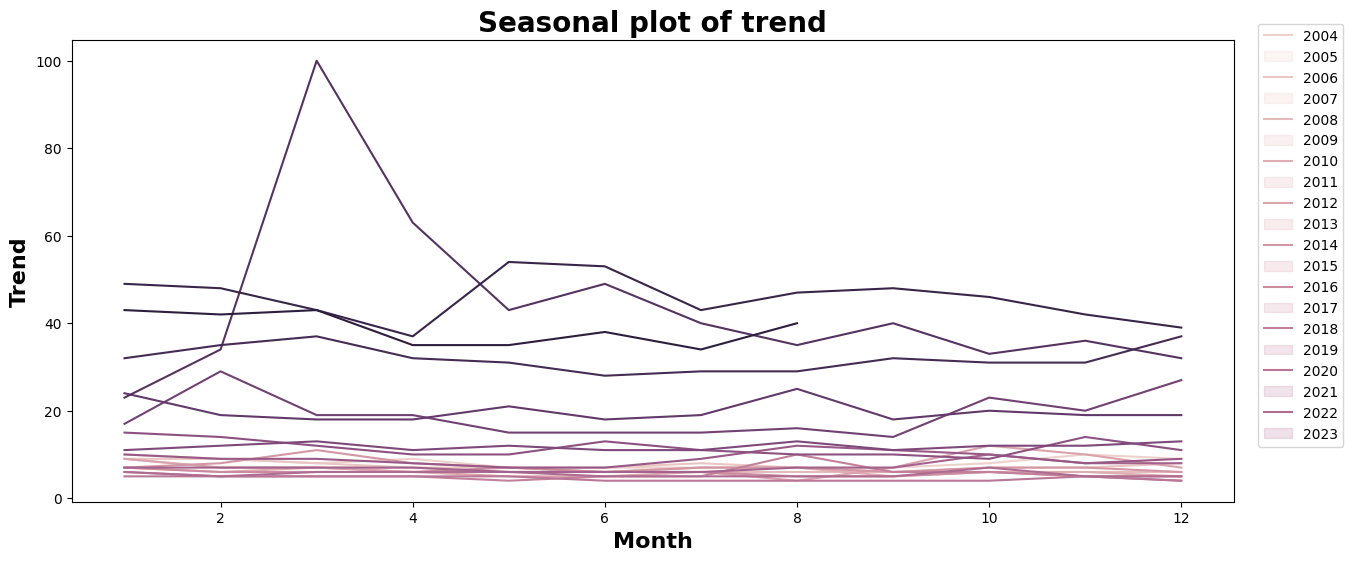

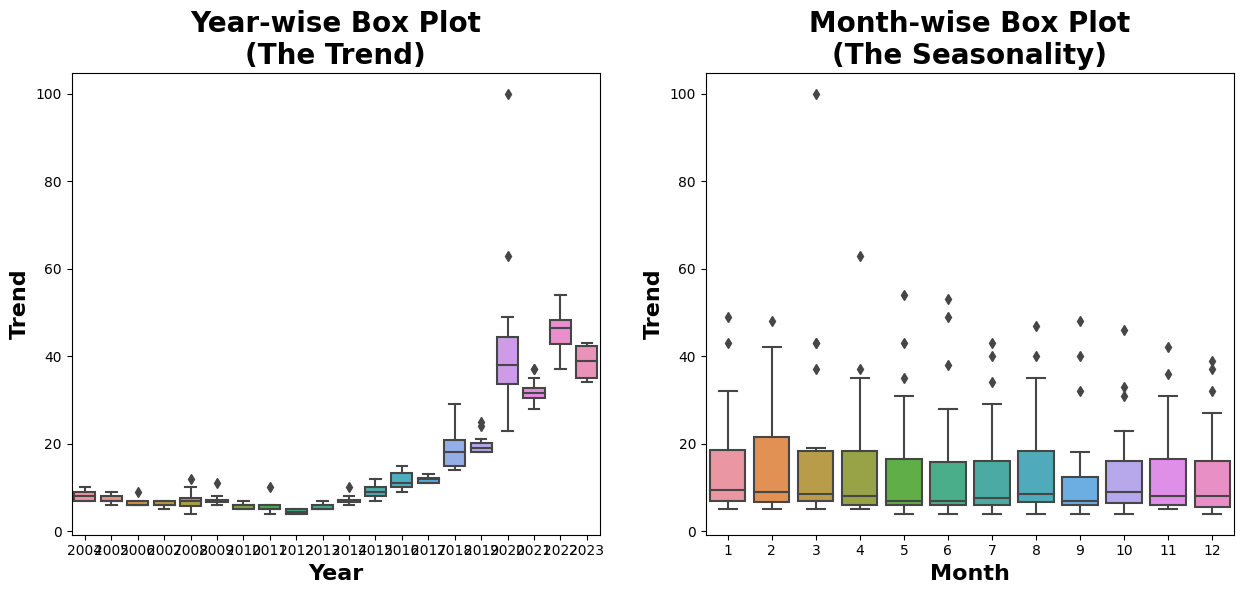

In [49]:
# seasonality of trend column
column = "month_trend"
# create a figure with one plot
_, ax = plt.subplots(figsize=(15, 6))

# plot the seasonal line plot
sns.lineplot(x=goog_trend_copy['month'], y=goog_trend_copy[column], hue = goog_trend_copy['year'])

# format the plot
ax.set_title('Seasonal plot of trend', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Trend', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend(labels = [str(2004+i) for i in range(20)], bbox_to_anchor=(1.1, 1.05))

# create a figure with two plots
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# plot the year-wise box plot
sns.boxplot(x=goog_trend_copy['year'], y=goog_trend_copy[column], ax=ax[0])

# format the year-wise box plot
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Trend', fontsize = 16, fontdict=dict(weight='bold'))

# plot the month-wise box plot
sns.boxplot(x=goog_trend_copy['month'], y=goog_trend_copy[column], ax=ax[1])

# format the month-wise box plot
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Trend', fontsize = 16, fontdict=dict(weight='bold'))

# rotate the x-axis labels for better readability
fig.autofmt_xdate()

**Seasonal plot of Volume**

>Dla poszczególnych lat nie widać wyraźnej sezonowości. Widoczny jest duży wzrost popularności frazy "S&P 500" w marcu 2020 r..

**Year wise Box Plot**

>Na tym wykresie trend jest przez pierwsze 10 lat i stabilny na równym poziomie. Następnie widać coraz większą popularność wyszukiwań, co może świadczyć o większej liczbie osób zainteresowanych inwestowaniem. Największą mediana wyniosła dla roku 2022. Największa zmienność jest dla roku 2020, co jest to związane z pandemią. Zmienność jest także widoczna dużo w tym roku.

**Month wise Box Plot**

>Nie są widoczne dużej rozbieżności. Nie można stwierdzić istniejącej sezonowości.

Text(0, 0.5, 'Trend')

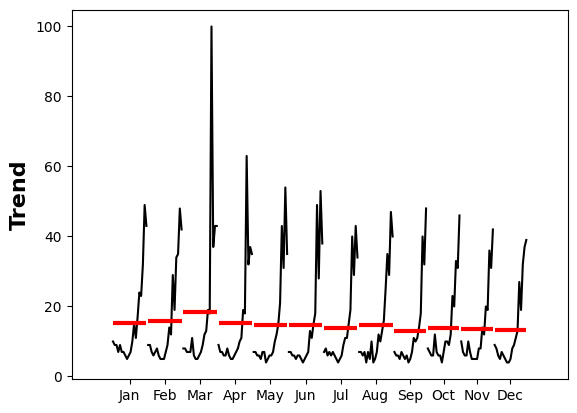

In [50]:
# aggregating trend to monthly scaled index
fig, ax = plt.subplots()

month_plot(goog_trend['month_trend'], ax=ax)
ax.set_ylabel('Trend', fontsize = 16, fontdict=dict(weight='bold'))

>Nie widać dużej zmienności dla poszczególnych miesięcy dla tych danych. Jedynie marzec ma większą średnią popularności. Co jest związane z marcem 2020 r. i osiągnięciem największej popularności. Znacznie większej niż dla innych okresów.

<div id="chap4"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Przetwarzanie wstępne danych</h1></div>

**<font color="#5963ab" size="4">sp500</font>**

In [51]:
# basic stats about data values
sp500.describe()

,open,high,low,close,volume,dividends,stock splits
count,4950.000000,4950.000000,4950.000000,4950.000000,4.950000e+03,4950.0,4950.0
mean,2099.723726,2111.689146,2086.960859,2100.110286,3.735805e+09,0.0,0.0
std,1051.776543,1057.550996,1045.629946,1051.937899,1.311274e+09,0.0,0.0
min,679.280029,695.270020,666.789978,676.530029,5.045800e+08,0.0,0.0
25%,1264.152527,1271.929993,1257.459961,1264.190033,3.030322e+09,0.0,0.0
50%,1754.695007,1765.330017,1747.054993,1755.869995,3.663470e+09,0.0,0.0
75%,2752.684937,2764.349915,2735.652527,2748.897461,4.334042e+09,0.0,0.0
max,4804.509766,4818.620117,4780.040039,4796.560059,1.145623e+10,0.0,0.0


In [52]:
# delete unneeded columns
del sp500['dividends']
del sp500['stock splits']
sp500

,open,high,low,close,volume
date,,,,,
2004-01-02 00:00:00-05:00,1111.920044,1118.849976,1105.079956,1108.479980,1153200000
2004-01-05 00:00:00-05:00,1108.479980,1122.219971,1108.479980,1122.219971,1578200000
2004-01-06 00:00:00-05:00,1122.219971,1124.459961,1118.439941,1123.670044,1494500000
2004-01-07 00:00:00-05:00,1123.670044,1126.329956,1116.449951,1126.329956,1704900000
2004-01-08 00:00:00-05:00,1126.329956,1131.920044,1124.910034,1131.920044,1868400000
...,...,...,...,...,...
2023-08-25 00:00:00-04:00,4389.379883,4418.459961,4356.290039,4405.709961,3296180000
2023-08-28 00:00:00-04:00,4426.029785,4439.560059,4414.979980,4433.310059,2957230000
2023-08-29 00:00:00-04:00,4432.750000,4500.140137,4431.680176,4497.629883,3354820000


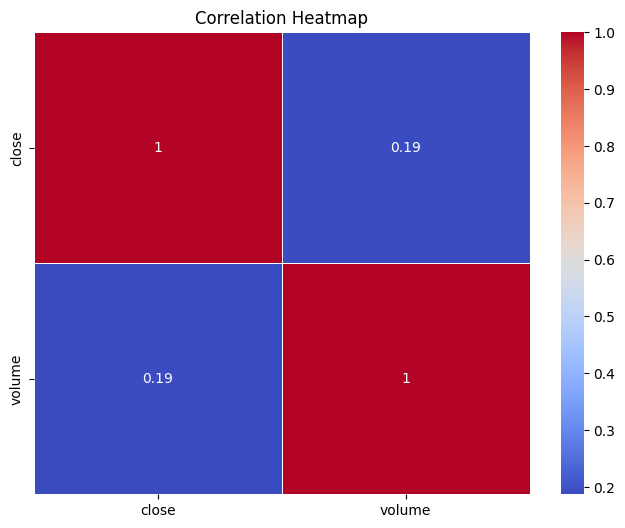

In [55]:
# calculate the correlation matrix
correlation_matrix = sp500.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

> Jak można było się domyślić, korelacja wynosi 1 dla czterech zmiennych odnoszących się do wyceny indeksu. Natomiast pomiędzy notowaniami indeksu a ilością wolumenu jest korelacja niewielka wynosząca 0,19.

In [56]:
# leave only close price column
del sp500['open']
del sp500['high']
del sp500['low']
sp500

KeyError: 'open'

In [58]:
# make a new column with daily price percent change
sp500['daily_pch'] = sp500['close'].pct_change() * 100
sp500

,close,volume,daily_pch
date,,,
2004-01-02 00:00:00-05:00,1108.479980,1153200000,NaN
2004-01-05 00:00:00-05:00,1122.219971,1578200000,1.239534
2004-01-06 00:00:00-05:00,1123.670044,1494500000,0.129215
2004-01-07 00:00:00-05:00,1126.329956,1704900000,0.236716
2004-01-08 00:00:00-05:00,1131.920044,1868400000,0.496310
...,...,...,...
2023-08-25 00:00:00-04:00,4405.709961,3296180000,0.671797
2023-08-28 00:00:00-04:00,4433.310059,2957230000,0.626462
2023-08-29 00:00:00-04:00,4497.629883,3354820000,1.450831


Text(0.5, 1.0, 'Daily Percent Change SP500 - Histogram')

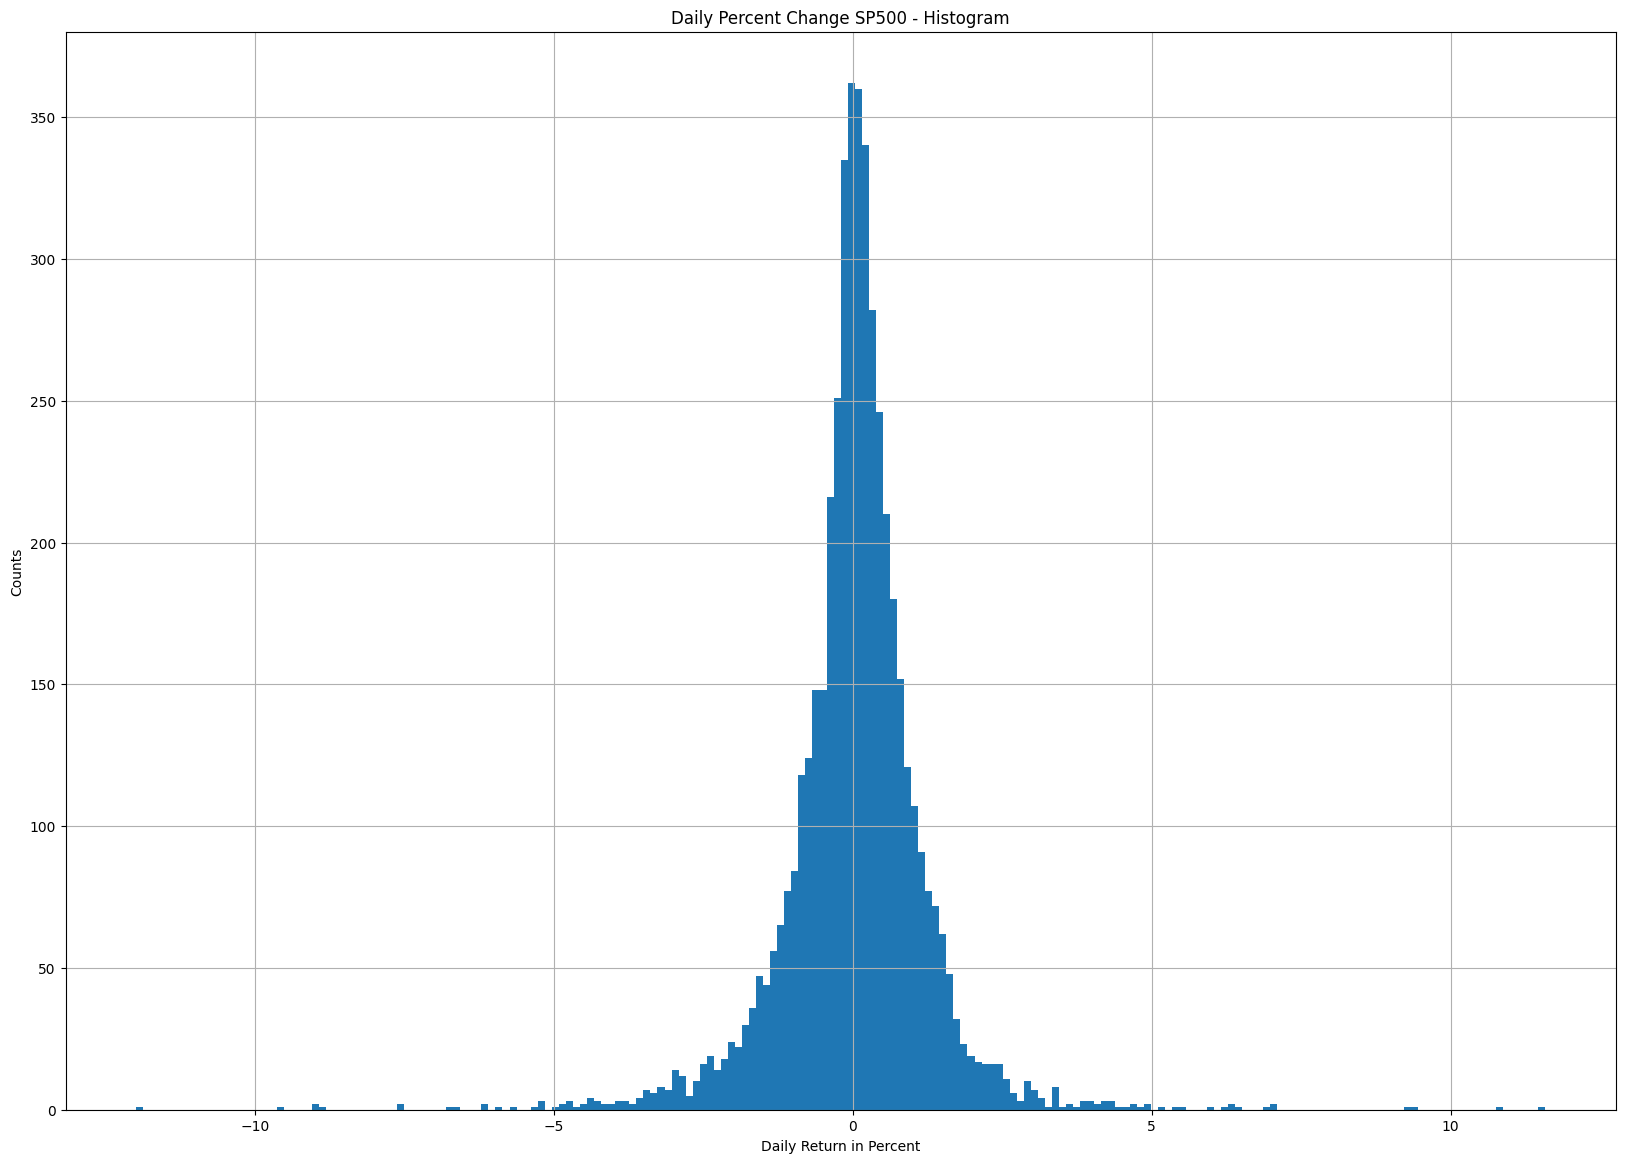

In [59]:
plt.figure(figsize=(20, 14))
sp500['daily_pch'].hist(bins=200)
plt.xlabel('Daily Return in Percent')
plt.ylabel('Counts')
plt.title('Daily Percent Change SP500 - Histogram')

In [60]:
# calculate the number of daily return above zero, equal to zero, and below zero
above_zero_count = (sp500['daily_pch'] > 0).sum()
equal_to_zero_count = (sp500['daily_pch'] == 0).sum()
below_zero_count = (sp500['daily_pch'] < 0).sum()

# Print the counts
print(f'Number of daily returns above zero: {above_zero_count}')
print(f'Number of daily returns equal to zero: {equal_to_zero_count}')
print(f'Number of daily returns below zero: {below_zero_count}')

Number of daily returns above zero: 2689
Number of daily returns equal to zero: 2
Number of daily returns below zero: 2258


In [61]:
# calculate the percent daily returns above zero, equal to zero, and below zero
num_rows = sp500.shape[0]

# Print the counts
print(f'Percent of daily returns above zero: {above_zero_count/num_rows*100:.2f}%')
print(f'Percent of daily returns equal to zero: {equal_to_zero_count/num_rows*100:.2f}%')
print(f'Percent of daily returns below zero: {below_zero_count/num_rows*100:.2f}%')

Percent of daily returns above zero: 54.32%
Percent of daily returns equal to zero: 0.04%
Percent of daily returns below zero: 45.62%


In [62]:
# calculate the percent change between the first and last day for index, total return fow whole period
first_row_value = sp500['close'].iloc[0]
last_row_value = sp500['close'].iloc[-1]
percent_change = ((last_row_value - first_row_value) / first_row_value) * 100

print(f'Percent change S&P 500 for index: {percent_change:.2f}%')

Percent change S&P 500 for index: 306.65%


>Z powyższych danych można zauważyć, że większość dni kończyła się pozytywnie dla inwestorów. Około 54.32% notowań zakończyło się na plusie dla indeksu S&P 500. W czasie okresu badań wynoszącego prawie 20 lat indeks wzrósł znacznie, ponieważ aż o 306.65%.

In [67]:
# create column "target" for prediction for next day - True if the index increases the next day, or False if it decreases
sp500["tomorrow"] = sp500["close"].shift(-1)
sp500.dropna(subset=['tomorrow'], inplace=True)
sp500["target"] = (sp500["tomorrow"]> sp500["close"]).astype(int)
del sp500['tomorrow']
sp500.head(10)

,close,volume,daily_pch,target
date,,,,
2004-01-02 00:00:00-05:00,1108.479980,1153200000,NaN,1
2004-01-05 00:00:00-05:00,1122.219971,1578200000,1.239534,1
2004-01-06 00:00:00-05:00,1123.670044,1494500000,0.129215,1
2004-01-07 00:00:00-05:00,1126.329956,1704900000,0.236716,1
2004-01-08 00:00:00-05:00,1131.920044,1868400000,0.496310,0
2004-01-09 00:00:00-05:00,1121.859985,1720700000,-0.888761,1
2004-01-12 00:00:00-05:00,1127.229980,1510200000,0.478669,0
2004-01-13 00:00:00-05:00,1121.219971,1595900000,-0.533166,1
2004-01-14 00:00:00-05:00,1130.520020,1514600000,0.829458,1


**<font color="#5963ab" size="4">nyt_hl</font>**

>Analiza sentymentu artykułów z dziennika New York Times.

In [68]:
nyt_hl_copy = nyt_hl.copy()
nyt_hl = nyt_hl_copy

In [69]:
nyt_hl['headline'].iloc[0]

['FreeMarkets Agrees to Buy Auction Unit of Covisint',
 'National Briefing | South: Arkansas: Assembly Fails To Meet Court-Mandated Deadline',
 'Clark Courts Veterans in Swing Through South',
 'Paid Notice: Deaths   PAONE, NICOLA',
 'The Time We Thought We Knew',
 'Mad Cow Disease: Lessons Unlearned (4 Letters)',
 'Giants Want a Teacher Who Is Adept at Winning',
 'An Odd Sight in Iran as Aid Team Tents Go Up: The U.S. Flag',
 'Mad Cow Disease: Lessons Unlearned',
 'Art Meets Artichoke',
 'Corrections',
 'Paid Notice: Deaths   BECKER, SCOTT',
 'A Place to Store Your Pictures, and to Show Them Off, Too',
 'Iranians Appear to Warm to Easing Tensions With U.S.',
 'So You Want to Be a Star? Help for Your Audition Tape',
 'Blocks; Capturing the Spirit of 1776, but With a Different Number',
 'Man Behind Sept. 11 Fund Describes Effort as a Success, With Reservations',
 'Paid Notice: Deaths   SIEGEL, ETHEL BEYERSKY',
 'CONGOLEUM FILES BANKRUPTCY PLAN WITH ASBESTOS LIABILITY',
 'For the Ex-Bucca

In [72]:
model_id = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model = model_id)

def find_sentiment(text):
    sent = sentiment_pipeline(text)[0]
    score = sent["score"]
    if sent["label"] == "NEGATIVE":
        score *= -1
    return score

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

C:\Users\jimiolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jimiolo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [70]:
nyt_hl

,headline,art_amount,word_count
date,,,
2004-01-01 00:00:00-05:00,[FreeMarkets Agrees to Buy Auction Unit of Cov...,224,1529
2004-01-02 00:00:00-05:00,"[Homeless in America, Yes, Today, Tony Cragg, ...",70,433
2004-01-03 00:00:00-05:00,"[AIMING TO MAKE FASTER CHIPS, AGERE ACQUIRES T...",158,1000
2004-01-04 00:00:00-05:00,"[Wanted: Young Delegates, Corrections, How to ...",516,3001
2004-01-05 00:00:00-05:00,"[Cowboys Preparing To Take Next Step, Paid Not...",182,1244
...,...,...,...
2023-08-27 00:00:00-04:00,"[Flashback: Your Weekly History Quiz, August 2...",63,548
2023-08-28 00:00:00-04:00,[Man Accused of Injecting Substance Into Neigh...,120,1142
2023-08-29 00:00:00-04:00,[President of Powerful Realtors’ Group Resigns...,135,1271


In [73]:
nyt_hl['sentiments'] = np.empty((len(nyt_hl), 0)).tolist()
nyt_hl['total_sent'] = 0
nyt_hl["sentiment"] = 0
nyt_hl["neg_sentiment"] = 0
for idx, headlines in enumerate (nyt_hl['headline'][0:1]): 
    total_sent = 0
    for headline in headlines:
        sent_result = find_sentiment(headline)
        total_sent += sent_result
        nyt_hl['sentiments'].iloc[idx].append(sent_result)
    nyt_hl['total_sent'].iloc[idx] = total_sent
    nyt_hl["sentiment"].iloc[idx] = mean(nyt_hl['sentiments'][idx])
    nyt_hl["neg_sentiment"].iloc[idx] = len([s for s in nyt_hl['sentiments'][idx] if s < 0]) / len(nyt_hl['sentiments'][idx])
    
    #del nyt_hl['sentiments'][idx]

C:\Users\jimiolo\AppData\Local\Temp\ipykernel_3300\2557955322.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyt_hl['total_sent'].iloc[idx] = total_sent
C:\Users\jimiolo\AppData\Local\Temp\ipykernel_3300\2557955322.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyt_hl["sentiment"].iloc[idx] = mean(nyt_hl['sentiments'][idx])
C:\Users\jimiolo\AppData\Local\Temp\ipykernel_3300\2557955322.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [74]:
nyt_hl
# Te obliczenia raz zrobić i zapisać je gdzieś. Później gotowe wczytywać by było szybciej.

,headline,art_amount,word_count,sentiments,total_sent,sentiment,neg_sentiment
date,,,,,,,
2004-01-01 00:00:00-05:00,[FreeMarkets Agrees to Buy Auction Unit of Cov...,224,1529,"[-0.605070948600769, -0.9997730851173401, 0.98...",-22.091328,-0.098622,0.553571
2004-01-02 00:00:00-05:00,"[Homeless in America, Yes, Today, Tony Cragg, ...",70,433,[],0.000000,0.000000,0.000000
2004-01-03 00:00:00-05:00,"[AIMING TO MAKE FASTER CHIPS, AGERE ACQUIRES T...",158,1000,[],0.000000,0.000000,0.000000
2004-01-04 00:00:00-05:00,"[Wanted: Young Delegates, Corrections, How to ...",516,3001,[],0.000000,0.000000,0.000000
2004-01-05 00:00:00-05:00,"[Cowboys Preparing To Take Next Step, Paid Not...",182,1244,[],0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2023-08-27 00:00:00-04:00,"[Flashback: Your Weekly History Quiz, August 2...",63,548,[],0.000000,0.000000,0.000000
2023-08-28 00:00:00-04:00,[Man Accused of Injecting Substance Into Neigh...,120,1142,[],0.000000,0.000000,0.000000
2023-08-29 00:00:00-04:00,[President of Powerful Realtors’ Group Resigns...,135,1271,[],0.000000,0.000000,0.000000


To raczej powinno być przeniesione do stworzenia modeli, bo tutaj są dane, ale można przygotować te dane, by były gotowe do użycia.


In [71]:
# crete new data frame to NLP process headlines for using further for investing prediction
nlp_data = pd.merge(sp500['target'], nyt_hl['headline'], on='date')
nlp_data

,target,headline
date,,
2004-01-02 00:00:00-05:00,1,"[Homeless in America, Yes, Today, Tony Cragg, ..."
2004-01-05 00:00:00-05:00,1,"[Cowboys Preparing To Take Next Step, Paid Not..."
2004-01-06 00:00:00-05:00,1,"[Paid Notice: Deaths LUSK, RUTH, Metro Brief..."
2004-01-07 00:00:00-05:00,1,[Rice and Ice Cream: An Oddly Appealing Couple...
2004-01-08 00:00:00-05:00,0,"[Sued by Estate Of Ex-Beatle, Doctor Offers Ac..."
...,...,...
2023-08-24 00:00:00-04:00,1,"[Terry Funk, Hard-Core Hall of Fame Wrestler, ..."
2023-08-25 00:00:00-04:00,1,[Spin. Pilates. Prigozhin? Presidential Busine...
2023-08-28 00:00:00-04:00,1,[Man Accused of Injecting Substance Into Neigh...


In [72]:
# calculate the index for the split point
split_point = int(0.8 * len(nlp_data))  # 80% for training, 20% for testing
split_point

3958

In [73]:
nlp_data.reset_index(drop = True, inplace = True)
# split the data into training and testing sets
train_data = nlp_data.iloc[:split_point]
test_data = nlp_data.iloc[split_point:]
test_data.reset_index(drop = True, inplace = True)

In [74]:
train_data

,target,headline
0,1,"[Homeless in America, Yes, Today, Tony Cragg, ..."
1,1,"[Cowboys Preparing To Take Next Step, Paid Not..."
2,1,"[Paid Notice: Deaths LUSK, RUTH, Metro Brief..."
3,1,[Rice and Ice Cream: An Oddly Appealing Couple...
4,0,"[Sued by Estate Of Ex-Beatle, Doctor Offers Ac..."
...,...,...
3953,1,"[After Tight Israeli Election, Netanyahu’s Ten..."
3954,0,"[We’re Not the Saudis’ Mercenaries, As Trump W..."
3955,0,[Deportation Exemptions to Resume for Immigran...
3956,0,"[Don’t Mess With Modi in Texas, Emmy Winners: ..."


In [75]:
test_data

,target,headline
0,0,[Group Behind California Privacy Law Aims to S...
1,0,[Person of Interest Is Named in Killing of Tra...
2,1,"[Just How Corrupt Is Bill Barr?, Ryan Murphy, ..."
3,0,[Hong Kong’s Status as Neutral Ground at Risk ...
4,0,[Trump’s Claims About Biden Aren’t ‘Unsupporte...
...,...,...
985,1,"[Terry Funk, Hard-Core Hall of Fame Wrestler, ..."
986,1,[Spin. Pilates. Prigozhin? Presidential Busine...
987,1,[Man Accused of Injecting Substance Into Neigh...
988,1,[President of Powerful Realtors’ Group Resigns...


In [76]:
# splitting the dataset
y_train = train_data['target']
train = train_data['headline']
y_test = test_data['target']
test = test_data['headline']

In [77]:
train.info()
train[0]

<class 'pandas.core.series.Series'>
RangeIndex: 3958 entries, 0 to 3957
Series name: headline
Non-Null Count  Dtype 
--------------  ----- 
3958 non-null   object
dtypes: object(1)
memory usage: 31.0+ KB


['Homeless in America, Yes, Today',
 'Tony Cragg',
 "'Home Sewn' -- 'Three Centuries of Stitching History'",
 'Cabbies Fear Fare Increase Will Hurt More Than It Helps',
 'Sports Briefing',
 '36 Hours | Ottawa',
 'Homeless in America, Yes, Today',
 'Paid Notice: Deaths   KELLY, JOSEPHINE (NEE MULLANE)',
 'Corrections',
 "A New Year's Tradition Lives, But the 4-Legged Star Doesn't",
 'When Steuben Glass Went Clear, Clean and Modern',
 "'108'",
 'Homeless in America, Yes, Today',
 'How Wild Was the Party? Ask the Army With the Brooms',
 '\x92Home Sewn\x92; Joe Deal; Don Celender',
 'POP AND JAZZ GUIDE',
 'Condos in Ski Areas: Your Own Place After a Day on the Slopes',
 'Egyptian Urges Arafat to Subdue Factions',
 "In Iraq's Murky Battle, Snipers Offer U.S. a Precision Weapon",
 "Some School Districts Challenge Bush's Signature Education Law",
 "Holiday Movies' Somber Embrace",
 'Paid Notice: Deaths   SMERLING, SYLVIA',
 'Killed in Iraq',
 'Residential Real Estate; Developer Sees Dream Far

In [78]:
train = train.apply(lambda x: '. '.join(x))
test = test.apply(lambda x: '. '.join(x))

In [79]:
train[0]

"Homeless in America, Yes, Today. Tony Cragg. 'Home Sewn' -- 'Three Centuries of Stitching History'. Cabbies Fear Fare Increase Will Hurt More Than It Helps. Sports Briefing. 36 Hours | Ottawa. Homeless in America, Yes, Today. Paid Notice: Deaths   KELLY, JOSEPHINE (NEE MULLANE). Corrections. A New Year's Tradition Lives, But the 4-Legged Star Doesn't. When Steuben Glass Went Clear, Clean and Modern. '108'. Homeless in America, Yes, Today. How Wild Was the Party? Ask the Army With the Brooms. \x92Home Sewn\x92; Joe Deal; Don Celender. POP AND JAZZ GUIDE. Condos in Ski Areas: Your Own Place After a Day on the Slopes. Egyptian Urges Arafat to Subdue Factions. In Iraq's Murky Battle, Snipers Offer U.S. a Precision Weapon. Some School Districts Challenge Bush's Signature Education Law. Holiday Movies' Somber Embrace. Paid Notice: Deaths   SMERLING, SYLVIA. Killed in Iraq. Residential Real Estate; Developer Sees Dream Farm; Others See Ruin of Wetlands. Bush Says Iran Must Do More Before Rel

In [80]:
# removing punctuation and special character from the text
train.replace(to_replace='[^a-zA-Z]', value=' ', regex=True, inplace=True)
test.replace(to_replace='[^a-zA-Z]', value=' ', regex=True, inplace=True)

In [81]:
train[0]

'Homeless in America  Yes  Today  Tony Cragg   Home Sewn      Three Centuries of Stitching History   Cabbies Fear Fare Increase Will Hurt More Than It Helps  Sports Briefing     Hours   Ottawa  Homeless in America  Yes  Today  Paid Notice  Deaths   KELLY  JOSEPHINE  NEE MULLANE   Corrections  A New Year s Tradition Lives  But the   Legged Star Doesn t  When Steuben Glass Went Clear  Clean and Modern         Homeless in America  Yes  Today  How Wild Was the Party  Ask the Army With the Brooms   Home Sewn   Joe Deal  Don Celender  POP AND JAZZ GUIDE  Condos in Ski Areas  Your Own Place After a Day on the Slopes  Egyptian Urges Arafat to Subdue Factions  In Iraq s Murky Battle  Snipers Offer U S  a Precision Weapon  Some School Districts Challenge Bush s Signature Education Law  Holiday Movies  Somber Embrace  Paid Notice  Deaths   SMERLING  SYLVIA  Killed in Iraq  Residential Real Estate  Developer Sees Dream Farm  Others See Ruin of Wetlands  Bush Says Iran Must Do More Before Relations

In [82]:
# converting the entire text to lower case
train = train.str.lower()
test = test.str.lower()

In [ ]:
# creating corpus of train dataset
ps = PorterStemmer()
train_corpus = []

for i in range(0, len(train)):
  
  # tokenizing the news-title by words
  words = train[i].split()

  # removing the stopwords
  words = [word for word in words if word not in set(stopwords.words('english'))]

  # stemming the words
  words = [ps.stem(word) for word in words]

  # joining the stemmed words
  headline = ' '.join(words)

  # building a corpus of news-title
  train_corpus.append(headline)

In [ ]:
train_corpus[0:1]

In [ ]:
# creating corpus of test dataset
test_corpus = []

for i in range(0, len(test)):
  
  # tokenizing the news-title by words
  words = test[i].split()

  # removing the stopwords
  words = [word for word in words if word not in set(stopwords.words('english'))]

  # stemming the words
  words = [ps.stem(word) for word in words]

  # joining the stemmed words
  headline = ' '.join(words)

  # building a corpus of news-title
  test_corpus.append(headline)

In [ ]:
test_corpus[0:1]

In [ ]:
down_words = []
for i in list(y_train[y_train==0].index):
  down_words.append(train_corpus[i])

up_words = []
for i in list(y_train[y_train==1].index):
  up_words.append(train_corpus[i])

In [ ]:
down_words_all = " ".join(down_words)
up_words_all = " ".join(up_words)

In [ ]:
# creating wordcloud for down_words
wordcloud_down = WordCloud(background_color='white', width=3000, height=2500).generate(down_words_all)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_down)
plt.axis('off')
plt.title("Words which indicate a fall in S&P 500")
plt.show()

In [ ]:
# creating wordcloud for up_words
wordcloud_up = WordCloud(background_color='white', width=3000, height=2500).generate(up_words_all)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_up)
plt.axis('off')
plt.title("Words which indicate a rise in S&P 500")
plt.show()

In [ ]:
# creating the Bag of Words model
cv = CountVectorizer(max_features=10000, ngram_range=(2,2))
X_train = cv.fit_transform(train_corpus).toarray()

In [ ]:
#test model to append to others features
X_train

In [ ]:
X_test = cv.transform(test_corpus).toarray()

In [ ]:
X_test

**<font color="#5963ab" size="4">macro_data - sp500_rates</font>**

In [ ]:
# to delete later copy to retrieve data if something went wrong
sp500_rates_copy = sp500_rates.copy()
sp500_rates_copy

In [ ]:
# plot all data
sp500_rates_plot = sp500_rates.plot.line( use_index = True)
sp500_rates_plot.set_ylabel("All rates for S&P 500")
sp500_rates_plot.set_title('S&P 500 Rates')
sp500_rates_plot.set_ylim(-10, 50)

In [ ]:
# calculate the correlation matrix
correlation_matrix = sp500_rates.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

>Na matrycy korelacji można zauważyć, że współczynniki P/E oraz Earning Yield są przeciwstawne do siebie, co jest zgodne ze sposobem ich obliczania. Widać także dużą pozytywną korelację pomiędzy współczynnikami CAPE, P/B, P/S, oraz dużą ujemną korelację pomiędzy tymi wskaźnikami a Dividend Yield.
>
> Ogólnie można zauważyć, że dane nie są bardzo skorelowane ze sobą, co jest korzystne do wykorzystania danych w modelach uczenia maszynowego. Niskie lub brak skorelowania między cechami może pomóc w zrozumieniu, jakie cechy wpływają na predykcje modelu Warto jednak eksperymentować z różnymi użytymi danymi i monitorować wydajność modelu oraz interpretować wyniki, aby dostosować podejście do optymalnego rozwiązania problemu.

**<font color="#5963ab" size="4">macro_data - usa_eco_rates</font>**

In [ ]:
# to delete later copy to retrieve data if something went wrong
usa_eco_rates_copy = usa_eco_rates.copy()
usa_eco_rates_copy

In [ ]:
# plot all data without GDP
usa_eco_rates_wo_gdp = usa_eco_rates.copy()
del usa_eco_rates_wo_gdp['gdp']
usa_eco_rates_plot = usa_eco_rates_wo_gdp.plot.line( use_index = True)
usa_eco_rates_plot.set_ylabel("All rates for USA market without GDP")
usa_eco_rates_plot.set_title('USA Economy Rates')

In [ ]:
# calculate the correlation matrix
correlation_matrix = usa_eco_rates.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

> Dane dla amerykańskiej gospodarki nie są bardzo skorelowane ze sobą. Można wyróżnić pozytywną korelację pomiędzy 10 US Bond Yield a EFFR, co jest zgodne z logiką, że rentowności obligacji skarbowych dążą do wartości efektywnych stóp procentowych. Drugą parą o dodatniej korelacji jest PMI Index i GDP Percent Change. Widać tutaj powiązanie, wzrostu PKB USA w danym okresie jest skorelowane z pozytywnym nastawieniem managerów do nabywania różnego rodzaju dóbr i usług.
>
> Największa ujemną korelację jest dla pary EFFR, Unemployment Rate. Co może być związane z polityką banków centralnych, którzy odpowiednio sterują stopami procentowymi i częstym kryterium do przyjęcia odpowiedniej strategii jest wartość bezrobocia w kraju. Drugą parą są wskaźniki GDP oraz 10 US Bond Yield. Co może być powiązane szczególnie z czasami kryzysu, w którym to PKB kraju często maleje, a inwestorzy inwestują w bezpieczniejsze aktywa jak obligacje.

**<font color="#5963ab" size="4">goog_trend</font>**

In [ ]:
# load the dataset
goog_trend = pd.read_csv('/kaggle/input/s-and-p500-google-trends/SP500_GoogleTrends.csv', index_col='date')
goog_trend.index = pd.to_datetime(goog_trend.index)
goog_trend.index = goog_trend.index.tz_localize('America/New_York')
goog_trend

In [ ]:
# calculate the difference between the current month and the previous month
goog_trend['month_diff'] = goog_trend['month_trend'].diff()
goog_trend

In [ ]:
# plot trend
#goog_trend_plot = goog_trend['month_diff'].plot.line( use_index = True)
goog_trend_plot = goog_trend.plot.line( use_index = True)
goog_trend_plot.set_ylabel("Month change in Trend")
goog_trend_plot.set_title('S&P 500 Changes in trend')

> Należy rozważyć, w projekcie czy warto używać wartości bezwzględnych, czy wartości względnych (zmian względem poprzedniego okresu). Oba podejścia mogą być cenne w różnych sytuacjach, dlatego należy rozważyć kilka kwestii, kiedy używać każdego z tych podejść. Oto krótkie charakterystyki podejść:
>
>**1. Wartości Bezwzględne:**
>
> - **Stabilne Trendy:** Jeśli Twoje dane wykazują stałe i spójne trendy w czasie, używanie wartości bezwzględnych może być dobrym wyborem. Na przykład, jeśli przewidujesz ceny akcji, sama absolutna cena może być bardziej informatywna niż zmiana w stosunku do poprzedniego dnia.
> - **Interpretowalność:** Wartości bezwzględne są często bardziej interpretowane, ponieważ reprezentują rzeczywiste pomiary lub ilości. Może to być istotne w przypadkach, gdy musisz wyjaśnić lub uzasadnić przewidywania przed interesariuszami.
>
>**2. Wartości Względne (Zmiany):**
>
> - **Sezonowość:** Gdy Twoje dane wykazują silne wzorce sezonowe lub cykliczne zachowanie, może być korzystne pracować z wartościami względnymi (zmianami). Na przykład w prognozowaniu sprzedaży może być bardziej informatywne modelowanie zmian miesiąc po miesiącu lub rok po roku niż same liczby sprzedaży.
> - **Stacjonarność:** Niektóre algorytmy uczenia maszynowego zakładają, że dane są stacjonarne, co oznacza, że właściwości statystyczne nie zmieniają się w czasie. W takich przypadkach modelowanie różnic między okresami może pomóc uczynić dane bardziej stacjonarnymi.
> - **Redukcja Szumu:** Modelowanie zmian może pomóc usunąć szum lub nieregularności w danych, co ułatwia modelowi skupienie się na ukrytych wzorcach.
>
>**3. Łączenie obu podjeść:**
>
> - W wielu przypadkach warto pracować zarówno z wartościami bezwzględnymi, jak i wartościami względnymi jako cechy. Na przykład możesz uwzględnić zarówno absolutną wartość zmiennej, jak i jej zmianę względem poprzedniego okresu jako osobne cechy w modelu. To może uwzględnić zarówno długoterminowe trendy, jak i krótkoterminową dynamikę w danych.

In [ ]:
# calculate the correlation matrix
correlation_matrix = goog_trend.corr()

# create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

>Można zauważyć, że jest nieduża korelacja pomiędzy absolutnymi wartościami trendów wyszukiwania a relatywnymi miesięcznymi zmianami dla trendu.

**<font color="#5963ab" size="4">analiza techniczna</font>**

Może tutaj merge wszystkich danych i zrobienie korelacji i innych rzeczy na tym podstawie wybranie ostatecznych danych do modeli.

<div id="chap5"><h1 style="color:white;background:#5963ab;border-radius:5px;padding:30px;font-family:'Arial', cursive;font-size:50px;text-align:center">Stworzenie modeli</h1></div>

**<font color="#5963ab" size="4">nyt_hl</font>**

**<font color="#5963ab" size="4">final data</font>**

In [ ]:
# create column for prediction for next day - True if the index increases the next day, or False if it decreases
sp500_predict = sp500.copy()
sp500_predict["tomorrow"] = sp500_predict["close"].shift(-1)
sp500_predict = sp500_predict.dropna()
sp500_predict["target"] = (sp500_predict["tomorrow"]> sp500_predict["close"]).astype(int)
sp500_predict

In [ ]:
# create data frame for storing all preprocessed data
#final_data = pd.DataFrame()
# copy all needed data from sp500 data to final_data
final_data = sp500_predict[['target', 'volume', 'close']]
final_data

>Wnioski
>
>Przewidywanie cen akcji na giełdzie jest od dawna przedmiotem zainteresowania zarówno analityków, jak i badaczy. Ceny akcji są trudne do przewidzenia ze względu na ich dużą zmienność, która zależy od różnorodnych czynników politycznych i ekonomicznych, zmiany przywództwa, nastrojów inwestorów i wielu innych czynników. Przewidywanie cen akcji na podstawie samych danych historycznych lub informacji tekstowych okazało się niewystarczające.